In [1]:
# outsource packages
import pyfolio as pf
import alphalens as al
import zipfile
import os
import alphalens as al
import quandl
import matplotlib.pyplot as plt
import datetime as datetime
import pandas as pd
import numpy as np
import talib
import seaborn as sns
from time import time,sleep
from sklearn import preprocessing
import pytz
import itertools
import warnings

warnings.filterwarnings("ignore")
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import yfinance as yf
yf.pdr_override()

In [2]:
# local packages
import risk_model
import factorize
import account
import utils_s
import feature_weights
import optimizer

In [3]:
secret_key = pd.read_csv('secret_key.txt',header=None)
quandl.ApiConfig.api_key = secret_key[0][0]

# 1 - Parameters

Before diving into factor research and quantitative analysis, we have to define parameters that will be used in different stages of this project. The purpose is to try different parameters to optimize our output portfolio during the time. The first parameter we set here below is `update_data` that is used to decide if we want to update the data or not.

In [4]:
update_data = True
if update_data:
    print ('ready to update data')
else:
    print ('data is already updated') 

ready to update data


## 1 - 1 - Time series data parameters

In this part, we set date parameters which are used for calling data from Quandl API. In this context, we call SEP/SHARADAR, DAILY/SHARADAR, and IFT/NSA for three years of data and SF1/SHARADAR for four years. The reason for this slicing is related to our final factor data where we look back one year. For example, some factors window length is set to one year, which means we need to load a minimum of three years data to chunk the final data frame in one year slice.

In [5]:
tod = datetime.datetime.today().date()
print ('current date: {}'.format(tod))

current date: 2020-08-11


In [6]:
# SF1
some_years = str(tod.year - 4)
month = str(tod.month)
day = str(tod.day)
start_f = '{}-{}-{}'.format(some_years,month,day)
print ('SF1 data starting date: {}'.format(start_f))

SF1 data starting date: 2016-8-11


In [7]:
# SEP & daily
two_years = str(tod.year - 3)
month = str(tod.month)
day = str(tod.day)
start_sep = '{}-{}-{}'.format(two_years,month,day)
print ('SEP,Daily and Sentiment data starting date: {}'.format(start_sep))

SEP,Daily and Sentiment data starting date: 2017-8-11


## 1 - 2 - Factor data period parameters

We set our final date parameter to one year factor data. The reason is that we believe more than one-year factor analysis will decrease our efficiency in prediction and could affect our interpretation of results.

In [8]:
# Slicing data for 1y
years_to_slice = 1
year = str(tod.year - years_to_slice)
month = str(tod.month)
day = str(tod.day)
ayear = '{}-{}-{}'.format(year,month,day)

start = ayear
end = str(tod)
print ('Final slicing date for {} year: {}'.format(years_to_slice,ayear))

Final slicing date for 1 year: 2019-8-11


## 1 - 3 - Universe parameters

The universe definition is an important step in this project. These parameters set here below will impact our analysis and need to be tuned as well as other parameters. metadata parameters are composed of `cap_select`, `exchange_select`, `currency_select` and `delisted_select` which are used to define our fisrt universe of stocks. For the second universe, `filteration_number` represents the number of liquid securities selected by dollar volume function and `smoothing_universe_period` represents the moving average window length in dollar volume function to select liquid securities smoothed over time. The following parameters are selected from the following values:

#### Market Cap:

- 1 - Nano
- 2 - Micro 
- 3 - Small 
- 4 - Mid 
- 5 - Large 
- 6 - Mega

#### Exhcange:

- NASDAQ 
- NYSE
- BATS
- NYSEARCA
- NYSEMKT
- OTC

#### Currency:

USD, EUR, ARS, AUD, BRL, CAD, CHF, CLP, <br>
CNY, COP, DKK, GBP, HKD, IDR, ILS, INR, <br>
JPY, KRW, MXN, MYR, NOK, NZD, PEN,PHP, <br>
PLN, RUB, SEK, TRY, TWD, ZAR

#### Delisted:

'Y' or 'N'

In [9]:
# metadata parameters
cap_select = ['6 - Mega', '5 - Large', '4 - Mid']
exchange_select = ['NYSE', 'NASDAQ']
currency_select = ['USD']
delisted_select = ['N']

In [10]:
# dollar volume parameters
filteration_number  = 400
smoothing_universe_period = 120

## 1 - 4 - Pipeline parameters

Creating factor data in a different way to obtain significant results is a critical subject treated in this project. The goal is to tune up the factor parameter to get optimal results. This section lets us test different parameters for these factors and navigates over different factor data. `smoothed_value` is the window length moving average parameter used to remove the noise created by factor variation. We will discuss other parameters in the factors section. 

In [11]:
smoothed_value = 5

In [12]:
fundamental_in = ['ncf','workingcapital','netinc','fcfps','roe']
momentum_in = {'momentum_252d':252,'momentum_120d':120 }
sma_in = {'sma200':200, 'sma100':100, 'sma50':50}
daily_in = {'marketcap':120, 'evebitda':100, 'ps':100, 'pe':100, 'pb':100}
over_in = {'overnight_sentiment_5d':5}
direction_in = {'direction_100d':100}
sent_in = {'sentiment_100d':100,'sentiment_60d':60}
vol_in = {'volatility_5d':5,'volatility_20d':20}
capm_in = {'capm_60d':60,'capm_20d':20,'capm_10d':10,'capm_5d':5}

## 1 - 5 - Factor analysis parameters

Here below we select periods to analyze our multi-factor output. These periods are selected according to our trading strategy and portfolio management methods. The `rebalance_period` is also an important parameter to choose carefully and consider commission fees in our portfolio management system. 

We use [Principal Component Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) in our risk management model to reduce the dimensionality of the risk factors. `factor exposures` parameter is the dimension that we want to reduce to it.

In [13]:
combined_periods = (5,10,20)
rebalance_period = 10

In [14]:
# Risk analysis
factor_exposures = 13

## 1 - 6 - Optimizer parameters

After combining factors we put it into the optimizer function which will maximize alpha factor and consider our risk model in counterpart. `risk_cap` is used to set the risk exposure parameter. More the risk is and more the alpha will be. `lambda_reg` is used regularized our optimized function. it is operating like a portfolio enhancer.

In [15]:
risk_cap = 0.05
lambda_reg = 0.5

In [16]:
assert risk_cap < 0.5
assert lambda_reg < 1

## 1 - 7 - Sector parameters

Our factor data is preprocessed and grouped by sector. Here below we can select sectors to drop, `sec_to_drop` regrouped sectors to not appear in factor data and our analysis to avoid sectors which have poor results. We also have the choice to drop specific sectors from long universe or short universe. For example the Tehnology sector shows good results in long qunatile and poor results in short quantile, it would be interesting to add this sector to `drop_short_sec`. The following parameter is selected from the following values:

#### Sectors:

- Basic Materials
- Communication Services
- Consumer Cyclical
- Consumer Defensive
- Energy
- Financial Services
- Healthcare
- Industrials
- Real Estate
- Technology
- Utilities
- None

In [17]:
sec_to_drop = ['Communication Services']

In [18]:
drop_long_sec = []
drop_short_sec = []

In [19]:
assert set(sec_to_drop) & set(drop_long_sec) == set()
assert set(sec_to_drop) & set(drop_short_sec) == set()
assert set(drop_long_sec) & set(drop_short_sec) == set()

## 1 - 9 - Quantiles

Here after the quantiles parameters are defining the equal portions of datas to be analyzed and considered for the future portfolio. `quantile_portions` is the number of qunatiles we want to analyze and work with. In the other hand `quantile_to_analysis` is the quantiles selected for the final analyze and portfolio. We use to select extremety quantiles to get the best results. 

In [20]:
qunatile_portions = 25
quantile_to_analyse = [1,qunatile_portions]

# 2 - Universe definition

## 2 - 1 - Benchmark

Before starting to define the universe, we have to prepare the benchmark. For this project the <b>S&P500</b> will be the reference index and we will use this data for our factor analysis.

In [21]:
# input
market = '^GSPC'
# read data 
dfm = yf.download(market,start_sep,end)

[*********************100%***********************]  1 of 1 completed


In [22]:
dfm = dfm.rename(columns={'Open': 'open', 
                          'High': 'high', 
                          'Low':'low', 
                          'Close':'close',
                          'Volume':'volume'}).drop('Adj Close', axis=1)
dfm.index.name = 'date'
# return
benchmark = dfm['close'].pct_change().loc[slice(start,end)]
benchmark.index = benchmark.index.tz_localize('UTC')

In [23]:
benchmark.head()

date
2019-08-12 00:00:00+00:00   -0.012317
2019-08-13 00:00:00+00:00    0.015132
2019-08-14 00:00:00+00:00   -0.029293
2019-08-15 00:00:00+00:00    0.002464
2019-08-16 00:00:00+00:00    0.014426
Name: close, dtype: float64

In this project, the universe is defined as a group of assets having high liquidy over a period. This universe will be used to compare systematic factors. Before proceeding to the selection of stocks we use `get_table` from Quandl API to load metadata of all stocks.

In the next step, we use our universe parameters to select the fisrt universe of stocks. The criteria for this selection are as followed:

- Exchange
- Market cap
- Currency
- Delisted

The following codes are used to define the first universe described above.

## 2 - 2 - Metadata

In [24]:
meta = quandl.get_table('SHARADAR/TICKERS', table='SF1',paginate=True)
meta.set_index('ticker',inplace=True, drop=True)

## 2 - 2 - 1 - First universe

In [25]:
if exchange_select:
    exchange = []
    for i in exchange_select:
        exchange.append(list(meta[(meta['exchange'] == i)].index))
    meta_ex = meta.loc[list(itertools.chain.from_iterable(exchange))]
else:
    meta_ex = meta

if currency_select:
    currency = []
    for i in currency_select:
        currency.append(list(meta_ex[(meta_ex['currency'] == i)].index))
    meta_ex_cu = meta_ex.loc[list(itertools.chain.from_iterable(currency))]
else:
    meta_ex_cu = meta_ex

if delisted_select:
    delisted = []
    for i in delisted_select:
        delisted.append(list(meta_ex_cu[(meta_ex_cu['isdelisted'] == i)].index))
    meta_ex_cu_de = meta_ex_cu.loc[list(itertools.chain.from_iterable(delisted))]
else:
    meta_ex_cu_de = meta_ex_cu
    
if cap_select:    
    cap = []
    for i in cap_select:
        cap.append(list(meta_ex_cu_de[(meta_ex_cu_de['scalemarketcap'] == i)].index))
    meta_ex_cu_de_cap = meta_ex_cu_de.loc[list(itertools.chain.from_iterable(cap))]
else:
    meta_ex_cu_de_cap = meta_ex_cu_de

In [26]:
u1 = list(meta_ex_cu_de_cap.index)

In [27]:
print ('{} assets selected in first selection'.format(len(u1)))

1996 assets selected in first selection


## 2 - 3 - OHLCV data

Once the `first_universe` is defined, we use it to get SHARADAR/SEP data and store this table as a zip file on the local drive. This table gives us the ohlcv data started at `start_sep` defined in the parameters section and ended at the current date `tod`. The zip file is extracted, sorted into a multi-index data frame, and finally cleaned using our local function `cleaning_dataframe` imported from `utils_s.py`.

In [28]:
if update_data:
    quandl.export_table('SHARADAR/SEP',
                        ticker = u1, 
                        date = {'gte': start_sep, 'lte': str(tod)}, 
                        filename = 'data/ohlcv.zip')

We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
data/ohlcv.zip


In [29]:
with zipfile.ZipFile('data/ohlcv.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'SEP':
        
        ohlcv = pd.read_csv(item)
        ohlcv['date'] = pd.to_datetime(ohlcv['date'])
        ohlcv = ohlcv.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        ohlcv.drop(['lastupdated','dividends','closeunadj'],axis=1,inplace=True)

        os.remove(item)

cleaning data
columns are clean


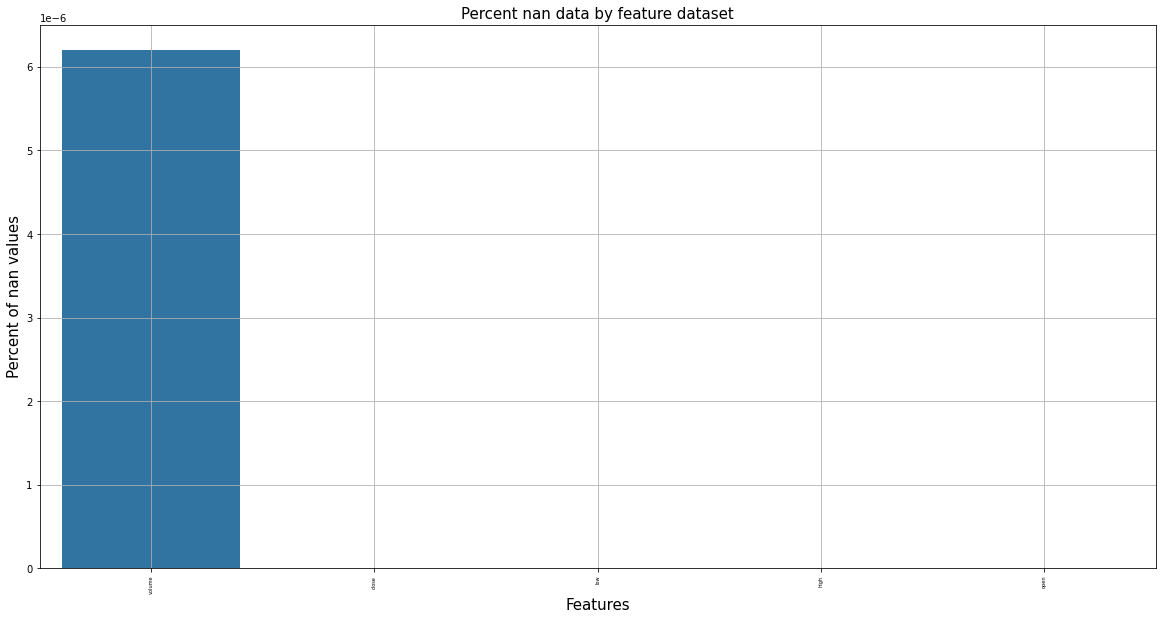

The percentage of dropped columns is 0%.
Dropped 0 columns out of 5


In [30]:
ohlcv = utils_s.cleaning_dataframe(ohlcv,0.2)

## 2 - 3 - 1 - Second universe

In this section, the `dollar_volume_universe` attends to select liquid stocks with significant market cap. In this context, the close frame is multiplied to volume to obtain the market cap data frame. Then we sort assets having the highest market cap. the number of assets selected is set in the parameters section through `filteration_number` and smoothed over time with `smoothing_universe_period`.

In [31]:
def dollar_volume_universe(tickers_num, ohlcv, sma_period):
    
    ohlcv['dollar_volume'] = ohlcv['close']*ohlcv['volume']
    dollar_vol = ohlcv['dollar_volume'].unstack('ticker')
    sma = pd.DataFrame(index = dollar_vol.index)
    try:
        for tick in dollar_vol.columns:
            sma[tick] = talib.SMA(dollar_vol[tick].values, timeperiod=sma_period)
    except:
        pass
    
    last = sma.iloc[-1,:]
    dol = pd.DataFrame(data = last.values,index = last.index, columns = ['dv'])
    dol.dropna(inplace = True)
    
    return list(dol.sort_values(by='dv', ascending=False).iloc[:tickers_num].index)    

In [32]:
universe = dollar_volume_universe(tickers_num = filteration_number, ohlcv = ohlcv, sma_period = smoothing_universe_period)

In [33]:
print ('{} assets selected out of {} for the second selection'.format(len(universe),len(u1)))

400 assets selected out of 1996 for the second selection


In [34]:
assert len(universe) == filteration_number

## 2 - 3 - 2 - Third universe

A sector selection model is a systematic tool that tilts a portfolio towards sectors that are predicted to outperform and underweights those that are predicted to underperform. If the process can effectively discern winning/losing industry groups, it can enhance the value added from a stock-selection methodology. Here below we use `sec_to_drop` which is composed of sectors to not include in the final assets (third universe). the output of this function will be the final selection.

In [35]:
universe_sectors = pd.DataFrame(index=universe, columns=['sectors'])
for i in universe:
    try:
        universe_sectors.loc[i] = meta_ex_cu_de_cap.loc[i]['sector']
    except:
        universe_sectors.loc[i] = np.nan
    try:
        for sec in sec_to_drop:
            if meta_ex_cu_de_cap.loc[i]['sector'] == sec:
                universe_sectors.drop(i, axis=0,inplace=True)
    except:
        pass

In [36]:
universe = list(universe_sectors.index)

In [37]:
print ('{} assets selected after sector cleaning out of {} for the third selection'.format(len(universe),len(u1)))

395 assets selected after sector cleaning out of 1996 for the third selection


## 2 - 4 - Fundamental data

After defining the final `universe`, we get fundamental SHARADAR/SF1 data and store this table as a zip file on the local drive. This table gives us the fundamental data of Most Recent Quarter (MRQ) Reported started at `start_f` defined in the parameters section and ended at the current date `tod`. The zip file is extracted, sorted into a multi-index data frame, and finally cleaned using our local function `cleaning_dataframe` imported from `utils_s.py`.

In [38]:
if update_data:
    #qopts={"columns":ind}
    quandl.export_table('SHARADAR/SF1',
                        ticker=universe, 
                        dimension = 'MRQ', 
                        calendardate={'gte':start_f,'lte':str(tod)}, 
                        filename='data/fundamental.zip')

We are generating the zip file now, please wait...
data/fundamental.zip


In [39]:
with zipfile.ZipFile('data/fundamental.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'SF1':
        sf1 = pd.read_csv(item)
        sf1 = sf1.set_index(['calendardate', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        sf1.drop(['datekey','reportperiod','lastupdated','dimension'],axis=1,inplace=True)
        os.remove(item)  

cleaning data
columns are clean


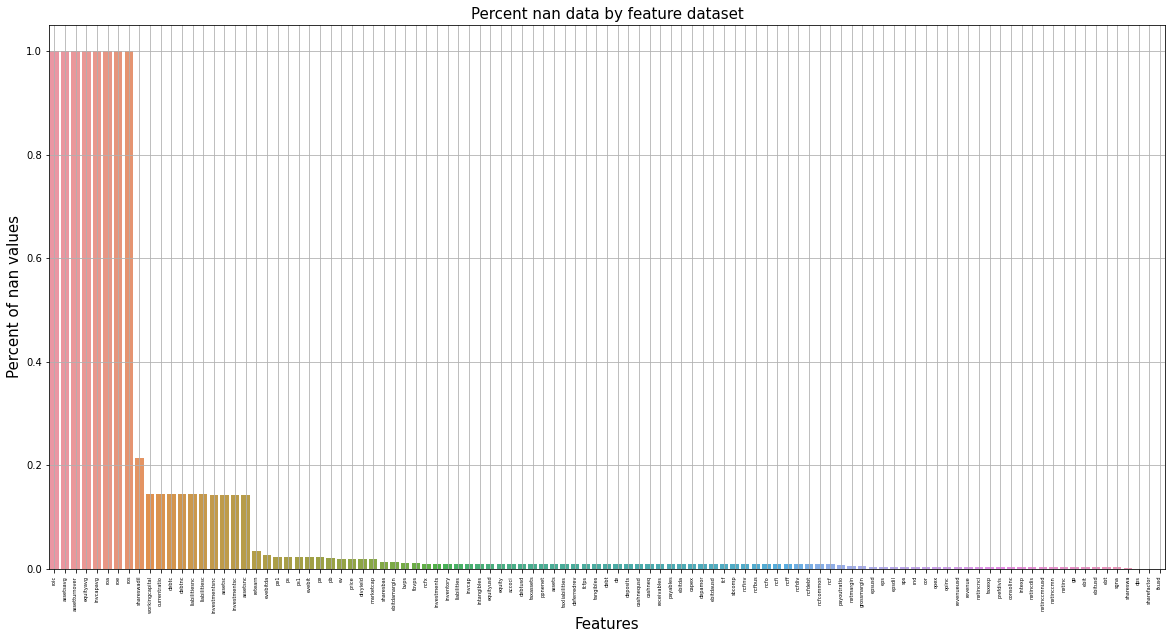

The percentage of dropped columns is 8%.
Dropped 9 columns out of 105


In [40]:
sf1 = utils_s.cleaning_dataframe(sf1,0.2)

In [41]:
sf1['roe'] = sf1['netinc'] / sf1['equity']
sf1['roa'] = sf1['netinc'] / sf1['assets']

## 2 - 5 - Daily metrics data

We continue to download data, here get daily metrics SHARADAR/DAILY data and store this table as a zip file on the local drive. This table gives us the data that with discussed in previously started at `start_sep` defined in the parameters section and ended at the current date `tod`. The zip file is extracted, sorted into a multi-index data frame, and finally cleaned using our local function `cleaning_dataframe` imported from `utils_s.py`.

In [42]:
if update_data:
    quandl.export_table('SHARADAR/DAILY',
                        ticker=universe, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename='data/daily.zip')

We are generating the zip file now, please wait...
data/daily.zip


In [43]:
with zipfile.ZipFile('data/daily.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'DAILY':
        daily = pd.read_csv(item)
        daily['date'] = pd.to_datetime(daily['date'])
        daily = daily.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        daily.drop(['lastupdated'],axis=1,inplace=True)
        os.remove(item) 

cleaning data
columns are clean


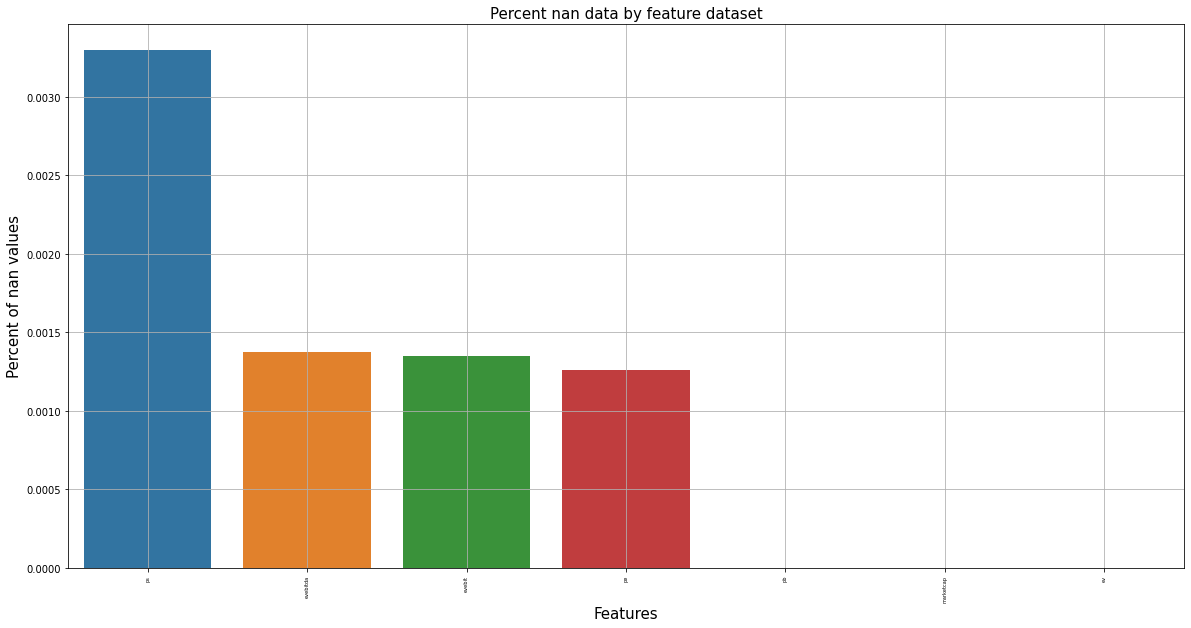

The percentage of dropped columns is 0%.
Dropped 0 columns out of 7


In [44]:
daily = utils_s.cleaning_dataframe(daily,0.2)

## 2 - 6 - Sentiment data

The last data we get is sentiment data IFT/NSA data and store this table as a zip file on the local drive. This table gives us the data that discussed previously started at `start_sep` defined in the parameters section and ended at the current date `tod`. The zip file is extracted, sorted into a multi-index data frame, and finally cleaned using our local function `cleaning_dataframe` imported from `utils_s.py`.

In [45]:
if update_data:
    quandl.export_table('IFT/NSA',
                        ticker=universe, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename='data/sent_test.zip')

We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
data/sent_test.zip


In [46]:
with zipfile.ZipFile('data/sent.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'IFT' and item.split('_')[1] == 'NSA':
        sent = pd.read_csv(item)
        sent['date'] = pd.to_datetime(sent['date'])
        sent = sent.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        sent = sent[sent['exchange_cd']=='US']
        sent.drop(['name','exchange_cd'],axis=1,inplace=True)
        os.remove(item) 

cleaning data
columns are clean


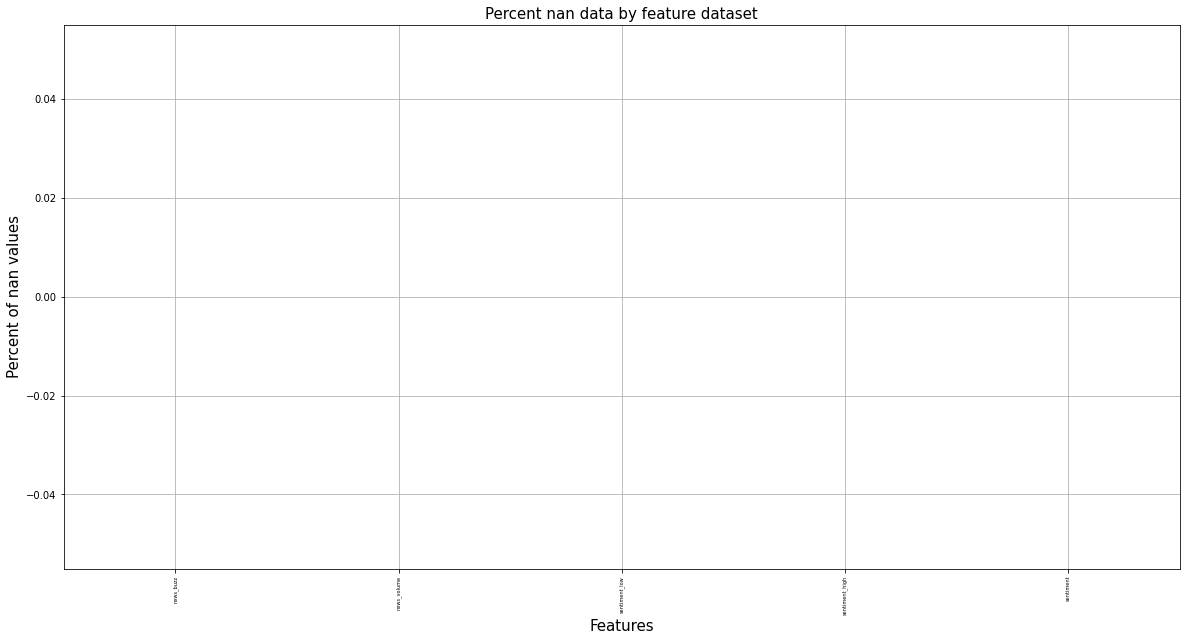

The percentage of dropped columns is 0%.
Dropped 0 columns out of 5


In [47]:
sent = utils_s.cleaning_dataframe(sent,0.2)

# 3 - Universe intersection

All the data is collected and stacked separately into a multi-index data frame. However, some of the assets defined previously in the universe section are dropped or not collected during the download and cleaning process. Therefore, the goal in this section is to get the intersection of assets represented for each data frame (`sent`,`sf1`,`daily` and `ohlcv`).

In [48]:
new_universe =list(set(sent['sentiment'].unstack('ticker').columns) & set(sf1.index.levels[1]) & set(daily.index.levels[1]) & set(ohlcv.index.levels[1]))

In [49]:
print ('{} assets dropped after intersectioning'.format((len(universe) - len(new_universe))))
print ('{} assets are loaded'.format(len(new_universe)))

26 assets dropped after intersectioning
369 assets are loaded


## 3 - 1- Sectors

The sectors represented in the cleaned data are as followed:

In [50]:
meta_cleaned = meta_ex_cu_de_cap.loc[new_universe,:]
print ('Sectors in cleaned data: \n')
sectors = {}
for i in set(meta_cleaned['sector']):
    print (' ',i)
    sectors[i] = list(meta_cleaned[meta_cleaned['sector'] == i].index)

Sectors in cleaned data: 

  Technology
  Financial Services
  Healthcare
  Consumer Cyclical
  Real Estate
  Consumer Defensive
  Basic Materials
  Utilities
  Industrials
  Energy


# 4 - Alpha factors

Factor-driven alpha investment strategies, designed to delivering market-beating returns, come in a number of different forms. In this porject, the following alpha factors are discussed:

- Daily Metrics
- Simple Moving Average
- Overnight Sentiment
- Mean Reversion
- Direction
- Sentiment Analysis
- Volatility
- Fundamentals

## 4 - 1 - Factorizing

These factors are generated as followed:

1 - Formulation <br>
2 - Scaling <br>
3 - Smoothing <br>
4 - Slicing <br>
5 - Neutralizing by Sector <br>
6 - Scaling <br>

Each of these factors of stored into a dictionary to be fetch into a final multiindex dataframe `all_factors` as the ouput of our pipleline. Once this is done, the multiindex data frame will be used as the input of other functions for analysis and optimization etc.

In [51]:
close = ohlcv['close'].unstack('ticker')[new_universe]
openn = ohlcv['open'].unstack('ticker')[new_universe]
high = ohlcv['high'].unstack('ticker')[new_universe]
low = ohlcv['low'].unstack('ticker')[new_universe]

In [52]:
pricing = openn.loc[slice(start,end),:].tz_localize('UTC')[new_universe]

### 4 - 1 - 1 - Daily Metrics

In [53]:
daily_data = {}

for i in daily_in.keys():
    
    df_daily = daily[i].unstack('ticker')
    # formulation and scaling
    reversion = factorize.Momentum(df_daily,daily_in[i])*-1
    # smoothing
    smoothed_reversion = factorize.Smooth(reversion,smoothed_value)
    # slicing
    smoothed_reversion.index = pd.to_datetime(smoothed_reversion.index)
    smoothed_reversion = smoothed_reversion.loc[slice(start,end),:]
    # neutralizing and scaling
    smoothed_reversion_neutralized_scaled = factorize.sector_neutral(sectors, smoothed_reversion)

    
    daily_data[i] = smoothed_reversion_neutralized_scaled[new_universe]


### 4 - 1 - 2 - Simple Moving Average

In [54]:
sma_data = {}

for name,period in sma_in.items():
    # formulation and scaling
    df= pd.DataFrame(index = close.index)

    try:
        for tick in close.columns:
            df[tick] = talib.SMA(close[tick].values, timeperiod=period)
    except:
        pass

    sma_min = ((close - df)/close) * -1
    # smoothing
    smoothed_sma_min = factorize.Smooth(sma_min,smoothed_value)
    # slicing
    smoothed_sma_min.index = pd.to_datetime(smoothed_sma_min.index)
    smoothed_sma_min = smoothed_sma_min.loc[slice(start,end),:]
    # neutralizing and scaling
    smoothed_sma_min_neutralized_scaled = factorize.sector_neutral(sectors, smoothed_sma_min)
    sma_data[name] = smoothed_sma_min_neutralized_scaled[new_universe]
    

### 4 - 1 - 3 - Overnight Sentiment

In [55]:
over_data = {}

for name,period in over_in.items():
    # formulation and scaling
    overnight_sentiment = factorize.overnight_sentiment(close, openn, 1, trailing_window=period)
    # smoothing
    smoothed_overnight_sentiment = factorize.Smooth(overnight_sentiment,smoothed_value)
    # slicing 
    smoothed_overnight_sentiment.index = pd.to_datetime(smoothed_overnight_sentiment.index)
    smoothed_overnight_sentiment = smoothed_overnight_sentiment.loc[slice(start,end),:]
    # neutralizing and scaling
    smoothed_overnight_sentiment_neutralized_scaled = factorize.sector_neutral(sectors, smoothed_overnight_sentiment)
    over_data[name] = (smoothed_overnight_sentiment_neutralized_scaled*-1)[new_universe]

### 4 - 1 - 4 - Mean Reversion

In [56]:
momentum_data = {}

for name,period in momentum_in.items():
    # formulation and scaling
    mean_reversion = factorize.Momentum(close,period)*-1
    # smoothing
    smoothed_mean_reversion = factorize.Smooth(mean_reversion,smoothed_value)
    # slicing
    smoothed_mean_reversion.index = pd.to_datetime(smoothed_mean_reversion.index)
    smoothed_mean_reversion = smoothed_mean_reversion.loc[slice(start,end),:]
    # neutralizing and scaling
    smoothed_mean_reversion_neutralized_scaled = factorize.sector_neutral(sectors, smoothed_mean_reversion)
    momentum_data[name] = smoothed_mean_reversion_neutralized_scaled[new_universe]

### 4 - 1 - 5 - Direction

In [57]:
direction_data = {}

for name,period in direction_in.items():
    
    # formulation and scaling
    direct = factorize.direction(close, openn, 1, period)
    # smoothing
    smoothed_direct = factorize.Smooth(direct,smoothed_value)
    # slicing
    smoothed_direct.index = pd.to_datetime(smoothed_direct.index)
    smoothed_direct = smoothed_direct.loc[slice(start,end),:]
    # neutralizing and scaling
    smoothed_direct_neutralized_scaled = factorize.sector_neutral(sectors, smoothed_direct)
    direction_data[name] = smoothed_direct_neutralized_scaled[new_universe]

### 4 - 1 - 6 - Sentiment Analysis

In [58]:
# sentiment
sent_data = {}

for name,period in sent_in.items():
    
    # formulation and scaling
    sentiment = factorize.sentiment(close, high, low, sent, period, new_universe)
    # smoothing
    smoothed_sentiment= factorize.Smooth(sentiment,smoothed_value)
    # slicing
    smoothed_sentiment.index = pd.to_datetime(smoothed_sentiment.index)
    smoothed_sentiment = smoothed_sentiment.loc[slice(start,end),:]
    # neutralizing and scaling
    smoothed_sentiment_neutralized_scaled = factorize.sector_neutral(sectors, smoothed_sentiment)
    sent_data[name] = smoothed_sentiment_neutralized_scaled[new_universe]

### 4 - 1 - 7 - Volatility

In [59]:
volatility_data = {}

for name,period in vol_in.items():
    
    # formulation and scaling
    vol = factorize.volatility(close, 5, period)
    # smoothing
    smoothed_vol = factorize.Smooth(vol,smoothed_value)
    # slicing
    smoothed_vol.index = pd.to_datetime(smoothed_vol.index)
    smoothed_vol = smoothed_vol.loc[slice(start,end),:]
    # neutralizing and scaling
    smoothed_vol_neutralized_scaled = factorize.sector_neutral(sectors, smoothed_vol)
    volatility_data[name] = smoothed_vol_neutralized_scaled[new_universe]

### 4 - 1 - 8 - Capm

In [60]:
capm_data = {}

for name,period in capm_in.items():
    
    # formulation and scaling
    cap = factorize.capm(close, dfm[['close']], 1, period)
    # smoothing
    smoothed_cap = factorize.Smooth(cap,smoothed_value)
    # slicing
    smoothed_cap.index = pd.to_datetime(smoothed_cap.index)
    smoothed_cap = smoothed_cap.loc[slice(start,end),:]
    # neutralizing and scaling
    smoothed_cap_neutralized_scaled = factorize.sector_neutral(sectors, smoothed_cap)
    capm_data[name] = smoothed_cap_neutralized_scaled[new_universe]


### 4 - 1 - 8 - Fundamentals

In [61]:
fund_data = {}

for i in fundamental_in:
    
    df = sf1[i].unstack('ticker')[new_universe]
    df.fillna(df.mean(axis=0),inplace=True)
    
    # formulation
    returns = factorize.Returns(df,window_length=1)
    returns.replace([np.inf, -np.inf], np.nan, inplace=True)    

    # neutralizing and scaling
    returns_neutralize_scaled = factorize.sector_neutral(sectors, returns)
    
    # resampling
    chunk = (ohlcv.index.levels[0][-1]+datetime.timedelta(days=1)).date()
    chunk_minus = ohlcv.index.levels[0][-1].date()
    returns_neutralize_scaled.loc[chunk,:] = np.nan
    returns_neutralize_scaled.index = pd.to_datetime(returns_neutralize_scaled.index)
    returns_neutralize_resampled = returns_neutralize_scaled.resample('D').pad()
    returns_neutralize_resampled = returns_neutralize_resampled.loc[ohlcv.index.levels[0][0]:chunk_minus,:]
    
    # drop holidays
    holidays = returns_neutralize_resampled.index ^ ohlcv.index.levels[0]
    returns_neutralize_resampled.drop(list(holidays),axis=0,inplace = True)
    returns_neutralize_resampled.index.name = ohlcv.index.levels[0].name
    
    # slicing
    returns_neutralize_resampled_1y = returns_neutralize_resampled.loc[slice(start,end),:]

    fund_data[i] = returns_neutralize_resampled_1y[new_universe]

## 4 - 4 - Multiindex factors

As mentioned before, factor data are unpacked and stacked into a multi-index data frame to finally be regrouped in a final multi-index data frame `all_factors`. The index is composed of two levels respectively `date` and `ticker`. The column is composed of factors created in previous sections relative to the date and ticker.

In [62]:
result = []

for i in fundamental_in:
    
    fund_return_neutralized_stacked = fund_data[i].stack().to_frame(i)
    result.append(fund_return_neutralized_stacked)

for i in daily_in.keys():

    daily_stacked = daily_data[i].stack().to_frame('daily_{}{}days'.format(i,daily_in[i]))
    result.append(daily_stacked)

for i in sma_data.keys():

    sma_stacked = sma_data[i].stack().to_frame('sma{}'.format(sma_in[i]))
    result.append(sma_stacked)

for i in momentum_data.keys():
    
    momentum_stacked = momentum_data[i].stack().to_frame('momentum{}days'.format(momentum_in[i]))
    result.append(momentum_stacked)
    
for i in over_data.keys():
    
    over_stacked = over_data[i].stack().to_frame('overnight_sent{}days'.format(over_in[i]))
    result.append(over_stacked)    

for i in direction_data.keys():
    
    direct_stacked = direction_data[i].stack().to_frame('direction{}days'.format(direction_in[i]))
    result.append(direct_stacked)
    
for i in volatility_data.keys():
    
    vol_stacked = volatility_data[i].stack().to_frame('volatility{}days'.format(vol_in[i]))
    result.append(vol_stacked)
    
for i in capm_data.keys():
    
    capm_stacked = capm_data[i].stack().to_frame('capm{}days'.format(capm_in[i]))
    result.append(capm_stacked)

for i in sent_data.keys():
    
    sent_stacked = sent_data[i].stack().to_frame('sentiment{}days'.format(sent_in[i]))
    result.append(sent_stacked)    
    
all_factors = pd.concat(result,axis=1)

all_factors.index.set_names(['date', 'asset'], inplace=True)

all_factors.index = all_factors.index\
                               .set_levels([all_factors.index.levels[0].tz_localize('UTC'), all_factors.index.levels[1]])

all_factors

ncf  workingcapital    netinc     fcfps  \
date                      asset                                                 
2019-08-12 00:00:00+00:00 A     -0.098489       -1.362058 -0.274148 -0.554181   
                          AAL    0.210356        0.203087  0.598856  0.838270   
                          AAPL  -0.224720        0.411182 -0.241389  0.397266   
                          ABBV  -0.094835       -0.180389 -0.210073 -1.226919   
                          ABT   -0.094993        0.516109 -0.244591  0.283526   
                          ACN   -0.302582        0.037211 -0.008705  0.429996   
                          ADBE  -0.027487        0.445931 -0.312129  0.170875   
                          ADI   -0.200651       -0.009072 -0.017961 -0.134232   
                          ADP    0.205965        0.263805  0.146730  0.435582   
                          ADSK   0.123338        0.433171  0.667923 -0.332326   
                          AEP    0.762972        0.659585  0.360079 -3.276396   
                          AFL    1.674951        1.035171  0.087372 -2.089009   
                          AGNC  -0.551193       -0.259211 -0.112220 -0.412984   
                          AIG    2.171016        1.035171 -0.361456 -1.049550   
                          AKAM  -0.164277        0.031421 -0.025283  0.587995   
                          ALGN  -0.095309        0.299697 -0.261350 -0.331178   
                          ALL    1.859374        1.035171 -0.770353 -0.957408   
                          ALXN  -0.095381        0.420480 -0.365690 -0.050152   
                          AMAT  -0.202211        0.007494  0.004514  0.337100   
                          AMD   -0.404722        0.036655  0.262772 -2.810115   
                          AMGN  -0.095338        0.097726 -0.287897 -1.258950   
                          AMT    0.214705       -0.260627  0.293658 -0.028918   
                          AMTD  -0.224160        1.035171  0.247660 -0.624036   
                          AMZN  -1.347164        0.257452 -0.469792 -0.294584   
                          ANET  -0.198281        0.047650 -0.397896  0.085687   
                          ANSS   0.237871        0.168075  0.195435 -0.577910   
                          ANTM  -0.095202        0.227049 -0.339882  0.142446   
                          AON    0.893332        0.309897 -0.283726  0.196196   
                          APA    3.065801        0.810271  0.342138  0.274361   
                          APD   -0.990325        2.159813  0.290167 -0.154311   
...                                   ...             ...       ...       ...   
2020-08-10 00:00:00+00:00 VLO   -0.484569        1.105810 -3.773348  0.479434   
                          VMC    0.040859       -0.130515  0.266863  0.263429   
                          VMW   -1.609592       -0.287331  0.752827 -0.654469   
                          VRSK  -0.350167        0.516041 -0.607957  0.080584   
                          VRTX  -0.095294       -1.343864 -0.283365 -0.343748   
                          VTR    0.133993       -0.351511  1.763160 -0.376217   
                          W      0.004912       -0.730210  2.696066  0.074777   
                          WBA    0.372707       -0.330210  1.002652 -0.310998   
                          WDAY  -0.960518       -1.402100  0.806243  0.116446   
                          WDC   -0.374891       -3.606395  0.797743  0.017267   
                          WEC   -0.251487        0.842905 -1.148981  0.266783   
                          WELL  -0.384810       -0.351511 -0.859721 -0.124219   
                          WFC    0.110194       -1.752943  2.326253 -0.126173   
                          WIX   -0.461128       -3.333131  1.209310 -0.231237   
                          WLTW   0.300364       -0.547384 -0.508327 -0.032391   
                          WM    -0.208765        1.433216 -1.069215  0.462491   
                          WMB   -0.513624       -0.872283 -3.799155  

In [63]:
all_factors['ncf_reversed'] = all_factors['ncf'] * -1
all_factors['fcfps_reversed'] = all_factors['fcfps'] * -1

In [64]:
# nan values per columns
all_factors.isna().sum()

ncf                       188
workingcapital              0
netinc                      0
fcfps                      63
roe                         0
daily_marketcap120days      0
daily_evebitda100days       0
daily_ps100days             0
daily_pe100days             0
daily_pb100days             0
sma200                      0
sma100                      0
sma50                       0
momentum252days             0
momentum120days             0
overnight_sent5days         0
direction100days            0
volatility5days             0
volatility20days            0
capm60days                  0
capm20days                  0
capm10days                  0
capm5days                   0
sentiment100days            0
sentiment60days             0
ncf_reversed              188
fcfps_reversed             63
dtype: int64

In [65]:
all_factors.describe()

ncf  workingcapital        netinc         fcfps           roe  \
count  92800.000000    92988.000000  92988.000000  92925.000000  92988.000000   
mean       0.000358       -0.144963     -0.127668      0.065908     -0.120977   
std        0.716354        1.247061      1.167799      0.953541      1.108724   
min       -3.865264       -3.841492     -3.872466     -3.871597     -3.871076   
25%       -0.251299       -0.335774     -0.472141     -0.299091     -0.400883   
50%       -0.072430        0.084139      0.047216      0.096738      0.025336   
75%        0.266926        0.361717      0.418247      0.461127      0.308152   
max        3.820022        3.872939      3.872606      3.863564      3.872982   

       daily_marketcap120days  daily_evebitda100days  daily_ps100days  \
count            9.298800e+04           9.298800e+04     9.298800e+04   
mean            -2.248432e-17          -1.562751e-16     1.987747e-16   
std              1.000005e+00           1.000005e+00     1.000005e+00   
min             -4.082105e+00          -8.296672e+00    -5.310033e+00   
25%             -7.934696e-01          -7.580564e-01    -7.762733e-01   
50%              2.140961e-03           1.952415e-02    -1.379501e-03   
75%              7.939268e-01           7.631343e-01     7.699005e-01   
max              4.242251e+00           8.135654e+00     4.541617e+00   

       daily_pe100days  daily_pb100days       ...        volatility5days  \
count     9.298800e+04     9.298800e+04       ...           9.298800e+04   
mean     -2.007495e-17     4.244704e-17       ...          -3.753993e-17   
std       1.000005e+00     1.000005e+00       ...           1.000005e+00   
min      -7.370374e+00    -6.108387e+00       ...          -5.576502e+00   
25%      -7.517532e-01    -7.757366e-01       ...          -5.900412e-01   
50%       1.780573e-02    -1.388318e-02       ...          -1.161755e-01   
75%       7.551355e-01     7.563415e-01       ...           4.423454e-01   
max       5.314651e+00     4.727739e+00       ...           6.398054e+00   

       volatility20days    capm60days    capm20days    capm10days  \
count      9.298800e+04  9.298800e+04  9.298800e+04  9.298800e+04   
mean       2.053437e-16  7.949268e-17  1.307701e-16  2.551932e-17   
std        1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00   
min       -3.895764e+00 -4.283202e+00 -5.066335e+00 -6.551171e+00   
25%       -6.575788e-01 -7.185765e-01 -6.005613e-01 -5.134632e-01   
50%       -9.554320e-02 -2.550280e-02 -2.095095e-02 -1.196162e-02   
75%        5.653912e-01  6.945451e-01  5.971974e-01  5.252985e-01   
max        4.860343e+00  4.158623e+00  5.071098e+00  6.133330e+00   

          capm5days  sentiment100days  sentiment60days  ncf_reversed  \
count  9.298800e+04      9.298800e+04     9.298800e+04  92800.000000   
mean  -2.531158e-18     -8.416696e-18     2.507052e-16     -0.000358   
std    1.000005e+00      1.000005e+00     1.000005e+00      0.716354   
min   -8.577119e+00     -5.820869e+00    -4.671354e+00     -3.820022   
25%   -4.376617e-01     -7.390216e-01    -6.503139e-01     -0.266926   
50%   -6.213520e-03     -3.562616e-02    -2.248001e-02      0.072430   
75%    4.403439e-01      7.019988e-01     6.202232e-01      0.251299   
max    8.564096e+00      4.999647e+00     4.517809e+00      3.865264   

       fcfps_reversed  
count    92925.000000  
mean        -0.065908  
std          0.953541  
min         -3.863564  
25%         -0.461127  
50%         -0.096738  
75%          0.299091  
max          3.871597  

[8 rows x 27 columns]

# 5 - All factors analysis

Now we have processed and regrouped factor data, we are ready to analyze the factor one by one to see if they have the potential to be combined or not. In this context, [alphalens](https://quantopian.github.io/alphalens/index.html) is used for the analysis. This package regrouped APIs useful for data processing and factor analysis over the pre-defined period `rebalance_period`. These metrics are as followed:


- <b>Cleaning and preparing data</b> `alphalens.utils.get_clean_factor_and_forward_returns`: Formats the factor data, pricing data, and group mappings into a DataFrame that contains aligned MultiIndex indices of timestamp and asset. The returned data will be formatted to be suitable for Alphalens functions. 

- <b>Cumulated factor return</b> `alphalens.performance.factor_returns`: Builds cumulative returns from ‘period’ returns. This function simulate the cumulative effect that a series of gains or losses (the ‘returns’) have on an original amount of capital over a period of time.

-  <b>Mean quantile return</b> `alphalens.performance.mean_return_by_quantile`: Computes mean returns for factor quantiles across provided forward returns columns.

- <b>Factor Rank Autocorrelation</b> `alphalens.performance.factor_rank_autocorrelation`: Computes autocorrelation of mean factor ranks in specified time spans. We must compare period to period factor ranks rather than factor values to account for systematic shifts in the factor values of all names or names within a group. This metric is useful for measuring the turnover of a factor. If the value of a factor for each name changes randomly from period to period, we’d expect an autocorrelation of 0.

- <b>Sharpe ratio</b> `sharpe_ratio`: This function computes annualized sharpe ratio. This metric is used to understand the return of an investment compared to its risk. The ratio is the average return earned in excess per unit of volatility or total risk. Volatility is a measure of the factor return fluctuations of an asset.

In [66]:
print ('Rebalance period set to {} days for all factors analysis'.format(rebalance_period))

Rebalance period set to 5 days for all factors analysis


In [67]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, 
                                                          prices=pricing, 
                                                          periods=[rebalance_period], 
                                                          quantiles=5,
                                                          filter_zscore=20,
                                                          max_loss=0.35)
    for factor, factor_data in all_factors[['capm20days',
                                            'sma200',
                                            'daily_ps100days',
                                            'daily_pb100days',
                                            'direction100days',
                                            'momentum252days',
                                            'sentiment100days',
                                            'overnight_sent5days',
                                            'volatility20days',
                                            'daily_marketcap120days',
                                            'daily_evebitda100days',
                                            'daily_pe100days',
                                            'ncf_reversed'
                                         ]].iteritems()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% en

### 5 - 1 - Cumulated factor return

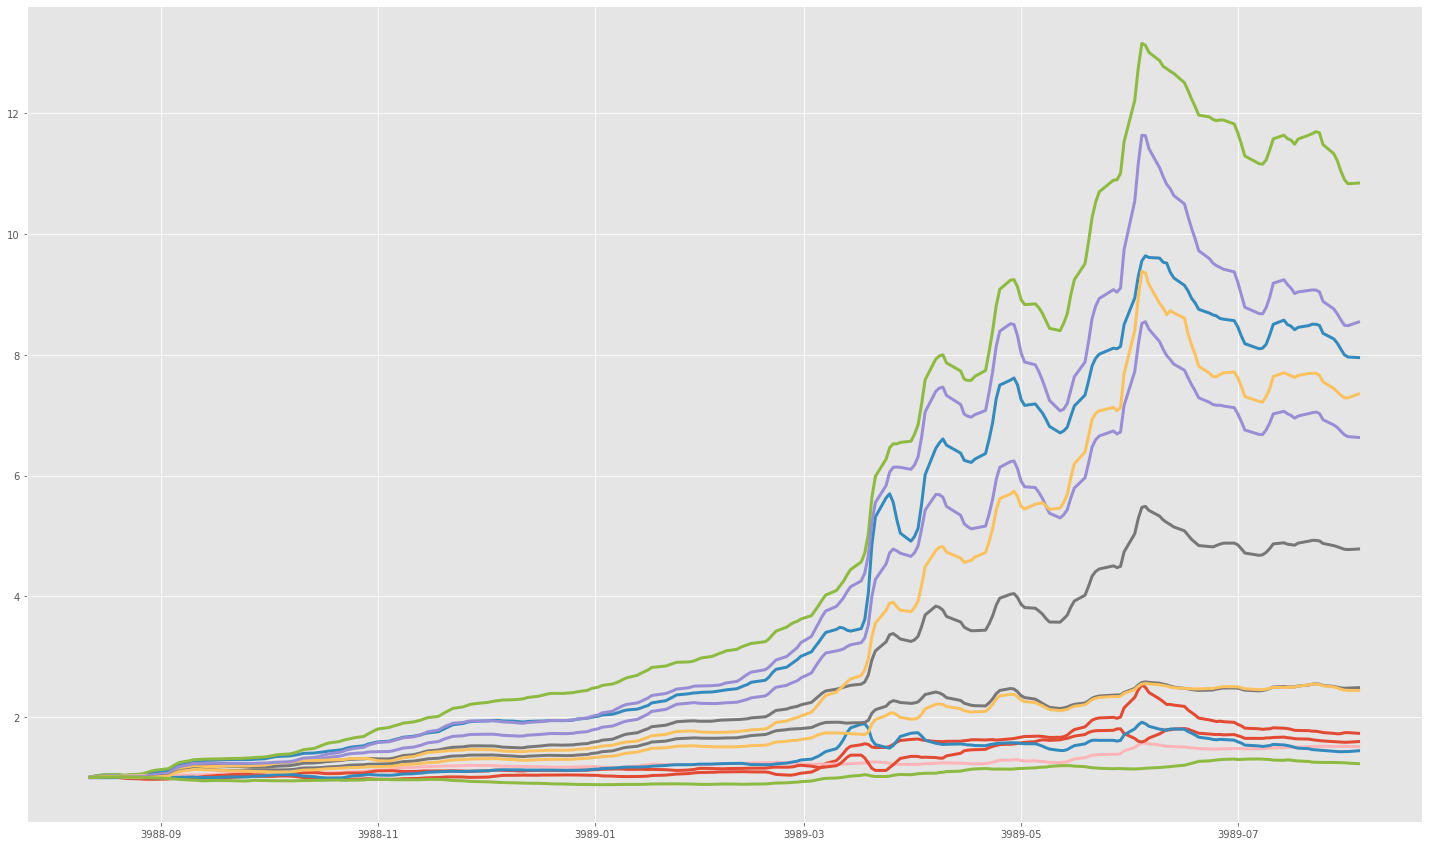

In [68]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (25, 15)

ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

plt.plot((1+ls_factor_returns).cumprod(), lw=3);

### 5 - 2 - Quantile analysis

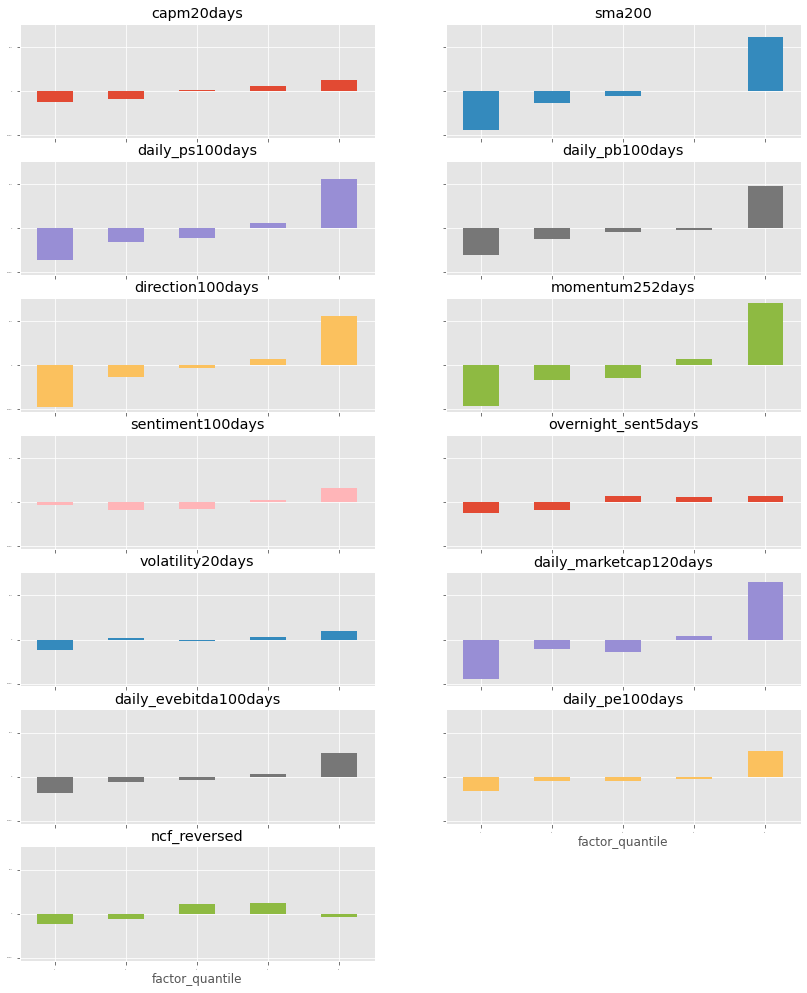

In [69]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(20,2),
    figsize=(14, 50),
    legend=False, fontsize=2);

### 5 - 3 - Factor Rank Autocorrelation

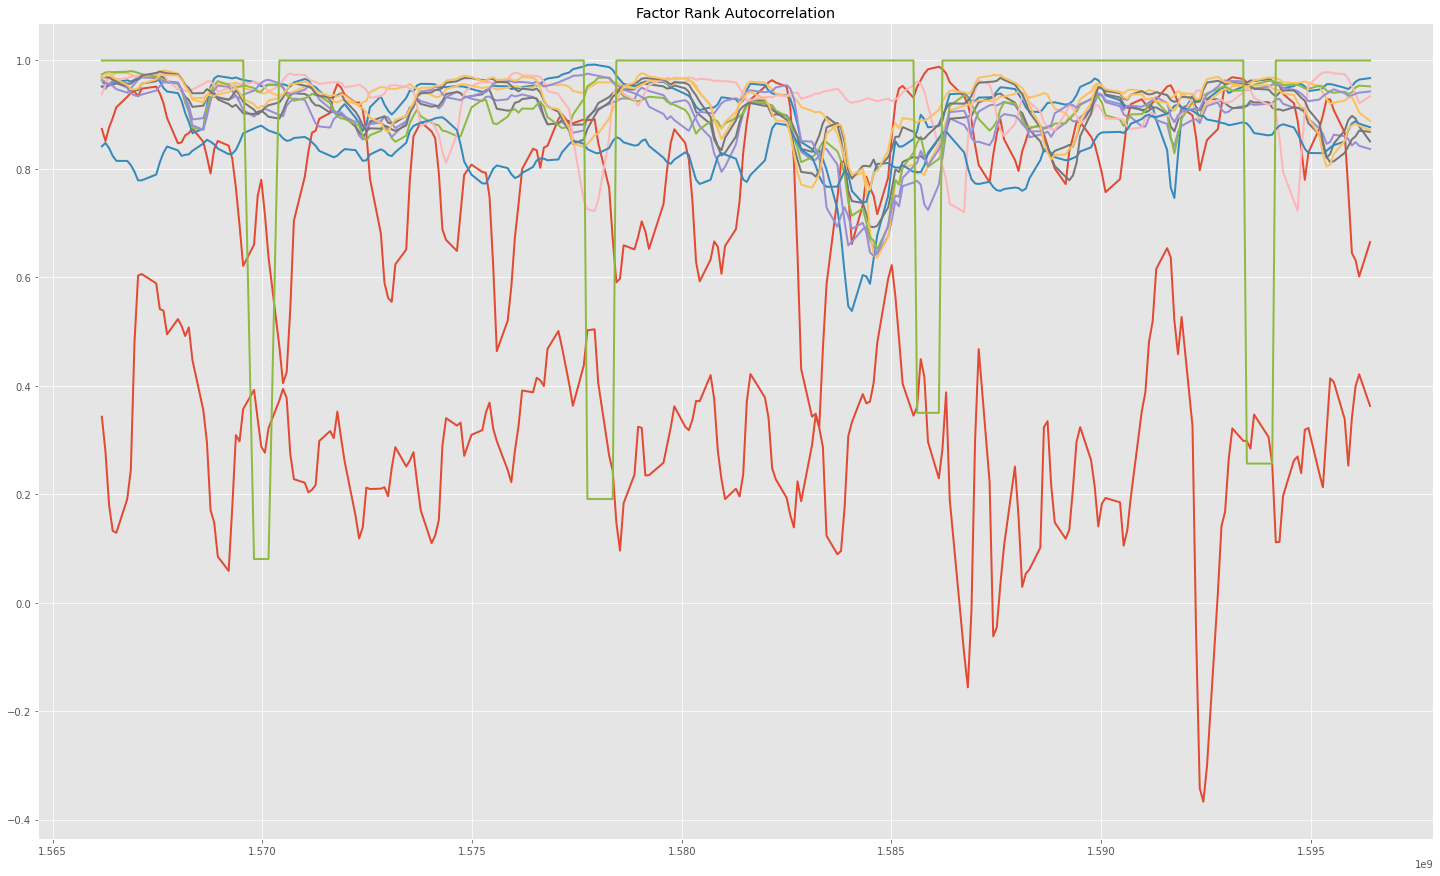

In [70]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data,period=rebalance_period)

plt.plot(ls_FRA,lw=2)
plt.title("Factor Rank Autocorrelation");

### 5 - 4 - Sharpe ratio

In [71]:
def sharpe_ratio(factor_returns, annualization_factor):

    df_sharpe = pd.Series(annualization_factor*factor_returns.mean()/factor_returns.std())
    
    return df_sharpe

In [72]:
daily_annualization_factor = np.sqrt(252)
df_sharpe = sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

In [73]:
df_sharpe.sort_values(ascending=False)

momentum252days           9.67
daily_marketcap120days    7.41
daily_pb100days           6.68
direction100days          6.66
daily_ps100days           6.50
sma200                    6.18
daily_evebitda100days     5.97
daily_pe100days           5.42
sentiment100days          4.61
ncf_reversed              2.66
capm20days                2.63
overnight_sent5days       2.41
volatility20days          1.61
dtype: float64

# 6 - Combined factors

## 6 - 1 - Combining selceted factors

In [74]:

selected_factors = [
                         'sma200',
                         'daily_ps100days',
                         'daily_pb100days',
                         'direction100days',
                         'momentum252days',
                         'sentiment100days',
                         'overnight_sent5days',
                         'volatility20days',
                         'daily_marketcap120days',
                         'daily_evebitda100days',
                         'daily_pe100days',
                         'ncf_reversed',
                         'capm20days'
                   ]

print('Selected Factors:\n{} '.format(',\n'.join(selected_factors)))

all_factors = all_factors[selected_factors]

Selected Factors:
sma200,
daily_ps100days,
daily_pb100days,
direction100days,
momentum252days,
sentiment100days,
overnight_sent5days,
volatility20days,
daily_marketcap120days,
daily_evebitda100days,
daily_pe100days,
ncf_reversed,
capm20days 


In [75]:
all_factors.to_csv('data/all_factors_test.csv')

Time to train full ML pipline: 7.537923812866211 secs
Accuracy on train set = 56.92%
Predictions: [ 1.  1. -1. ...  1. -1. -1.]
Probabilities of class == 1: [50.07104237 50.01637561 49.98353332 ... 50.11854143 49.93595008
 43.81071469]
Accuracy on test set = 49.25%
Log-loss = 0.69325


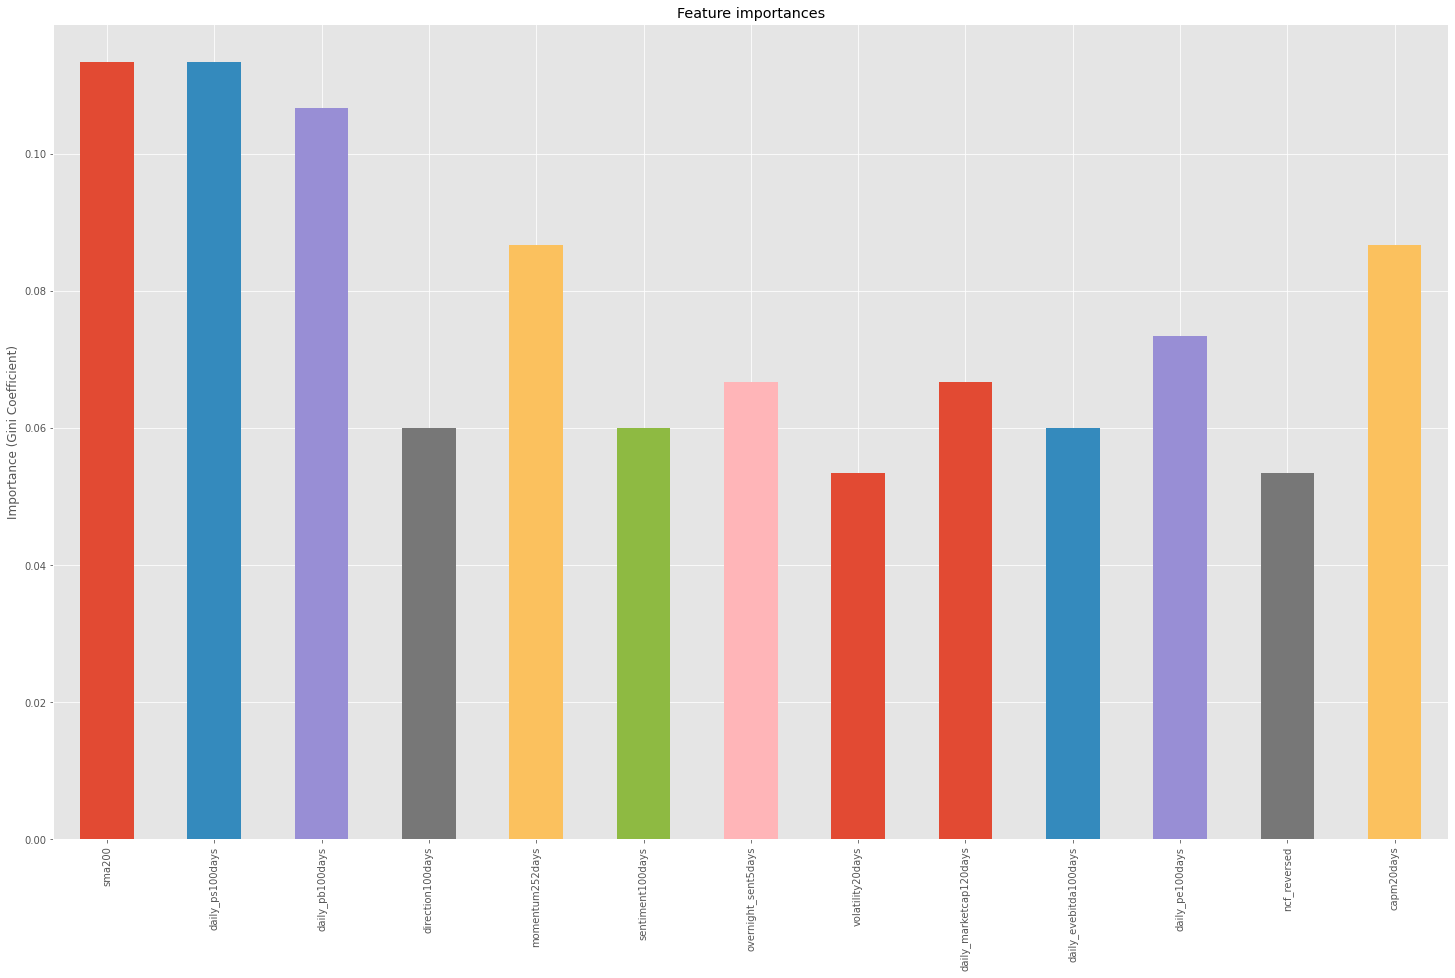

In [76]:
feature_importances = feature_weights.feature_importance(n_fwd_days = rebalance_period, 
                                                         close = close, 
                                                         all_factors = all_factors,
                                                         lower_percentile = 20,
                                                         upper_percentile = 80)

In [77]:
feature_importances.sort_values(by='weights')

weights
factors                         
volatility20days        0.053333
ncf_reversed            0.053333
direction100days        0.060000
sentiment100days        0.060000
daily_evebitda100days   0.060000
overnight_sent5days     0.066667
daily_marketcap120days  0.066667
daily_pe100days         0.073333
momentum252days         0.086667
capm20days              0.086667
daily_pb100days         0.106667
sma200                  0.113333
daily_ps100days         0.113333

In [78]:
all_factors_copy = all_factors.copy() 

In [79]:
for factor in selected_factors:
    all_factors_copy.loc[:,factor] = feature_importances.loc[factor][0] * all_factors.loc[:,factor]
all_factors_copy.loc[:,'alpha_vector'] = all_factors.sum(axis=1)
all_factors = all_factors_copy  

In [80]:
vec = pd.DataFrame(data=all_factors['alpha_vector'],columns = ['alpha_vector','sector'])
for date in vec.index.levels[0]:
    vec.loc[date,['sector']] = meta_ex_cu_de_cap.loc[vec.index.levels[1]]['sector'].values
sectors = vec['sector']

In [81]:
vec.shape

(92988, 2)



## 6 - 2 - Creating clean factor data

In [82]:
factor_data = al.utils.get_clean_factor_and_forward_returns(factor = all_factors['alpha_vector'], 
                                                          prices = pricing, 
                                                          periods = combined_periods,
                                                          quantiles = qunatile_portions,
                                                          groupby=sectors,
                                                          binning_by_group=False,
                                                          filter_zscore=20,
                                                          max_loss=0.15)

Dropped 7.9% entries from factor data: 7.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 15.0%, not exceeded: OK!


## 6 - 3 - Creating tear sheets 

In [83]:
pf_returns, pf_positions, pf_benchmark = \
al.performance.create_pyfolio_input(factor_data,
                                       period='{}D'.format(rebalance_period),
                                       capital=1,
                                       long_short=True,
                                       group_neutral=False,
                                       equal_weight=False,
                                       #quantiles=[1,2,4,5],
                                       groups=sectors)

In [90]:
pf_benchmark = benchmark.loc[slice(pf_returns.index[0],pf_returns.index[-1])]

In [91]:
sec_mappings = sectors.loc[pd.IndexSlice[pf_returns.index[0]]]

In [92]:
sector_mappings = {}
for i in sec_mappings.index:
    sector_mappings[i] = sec_mappings.loc[i]

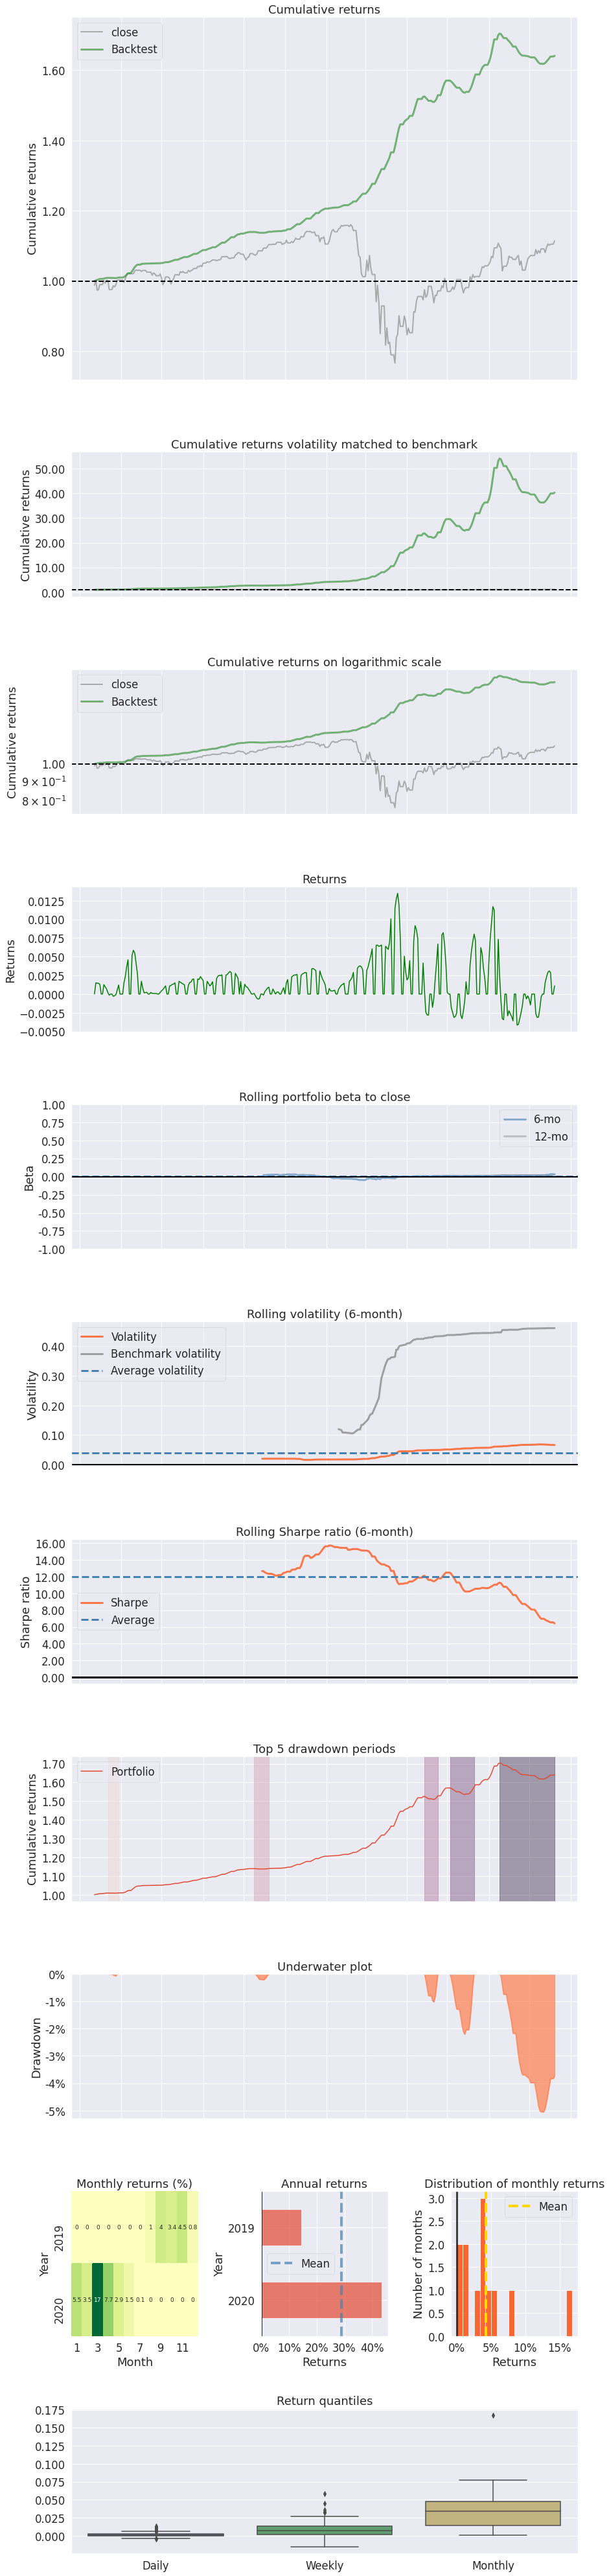

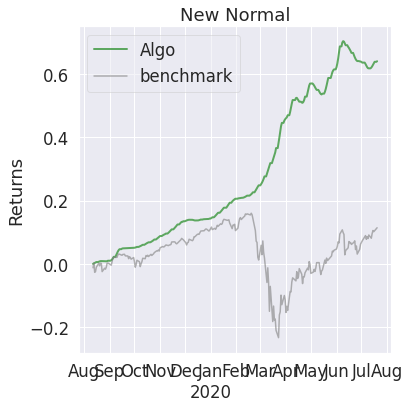

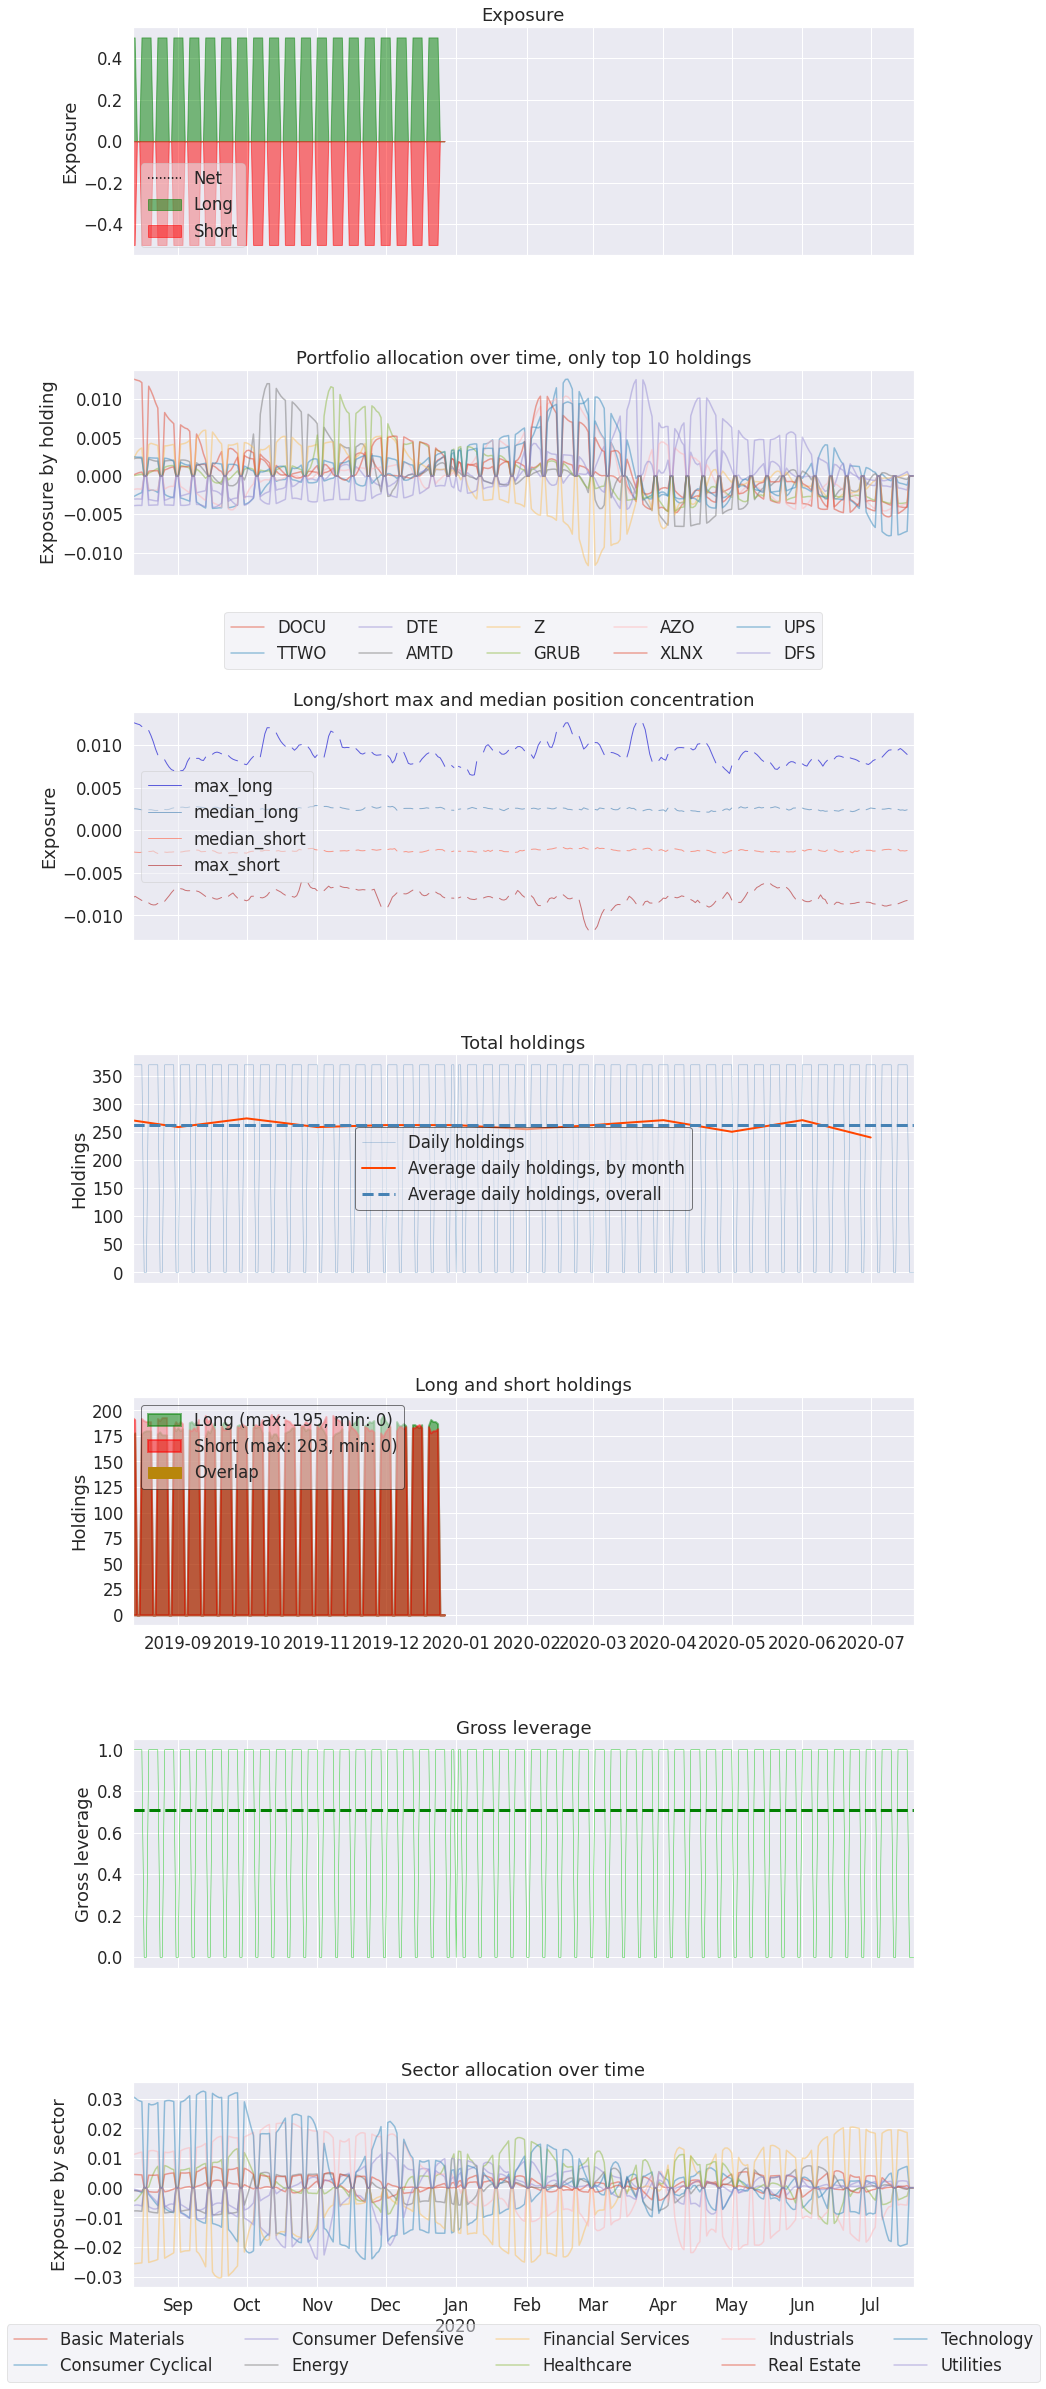

In [93]:
pf.create_full_tear_sheet(returns = pf_returns, 
                          positions = pf_positions,
                          sector_mappings = sector_mappings,
                          benchmark_rets = pf_benchmark )

Quantiles Statistics


min        max       mean       std  count   count %
factor_quantile                                                            
1               -22.790144  -8.560499 -12.766168  2.198979   3480  4.065041
2               -15.837285  -6.720092 -10.119104  1.480669   3480  4.065041
3               -12.560012  -5.532362  -8.615231  1.282694   3480  4.065041
4               -10.704708  -4.718242  -7.518598  1.180858   3248  3.794038
5                -9.570592  -3.964708  -6.567974  1.082219   3480  4.065041
6                -8.413380  -2.964894  -5.663673  1.000569   3480  4.065041
7                -7.215560  -2.442010  -4.800411  0.910704   3480  4.065041
8                -6.100995  -1.927487  -4.002240  0.788349   3248  3.794038
9                -4.936273  -1.273517  -3.232642  0.705896   3480  4.065041
10               -4.014144  -0.836631  -2.481985  0.631223   3480  4.065041
11               -3.255039  -0.038608  -1.750962  0.603767   3248  3.794038
12               -2.580280   0.697025  -1.022735  0.625553   3480  4.065041
13               -1.724642   1.325866  -0.248354  0.626989   3480  4.065041
14               -0.971413   2.098068   0.538297  0.619121   3480  4.065041
15               -0.185779   3.031989   1.308653  0.619640   3248  3.794038
16                0.526251   3.933402   2.084468  0.666414   3480  4.065041
17                1.366638   5.271876   2.879119  0.737633   3480  4.065041
18                2.071974   6.372882   3.729023  0.811931   3248  3.794038
19                2.792411   7.903357   4.628995  0.909515   3480  4.065041
20                3.751021   8.711051   5.588295  0.991793   3480  4.065041
21                4.389109  10.622241   6.635074  1.145505   3480  4.065041
22                4.987268  11.659859   7.695633  1.266745   3248  3.794038
23                5.841091  12.659983   8.879104  1.407180   3480  4.065041
24                7.548211  14.975885  10.466283  1.651007   3480  4.065041
25                9.099336  30.652438  13.553397  2.758108   3480  4.065041

Returns Analysis


5D      10D      20D
Ann. alpha                                       0.659    0.580    0.494
beta                                             0.131   -0.004   -0.021
Mean Period Wise Return Top Quantile (bps)     223.572  189.703  165.911
Mean Period Wise Return Bottom Quantile (bps) -173.722 -137.322 -119.102
Mean Period Wise Spread (bps)                  397.295  325.729  284.661

<Figure size 1800x1080 with 0 Axes>

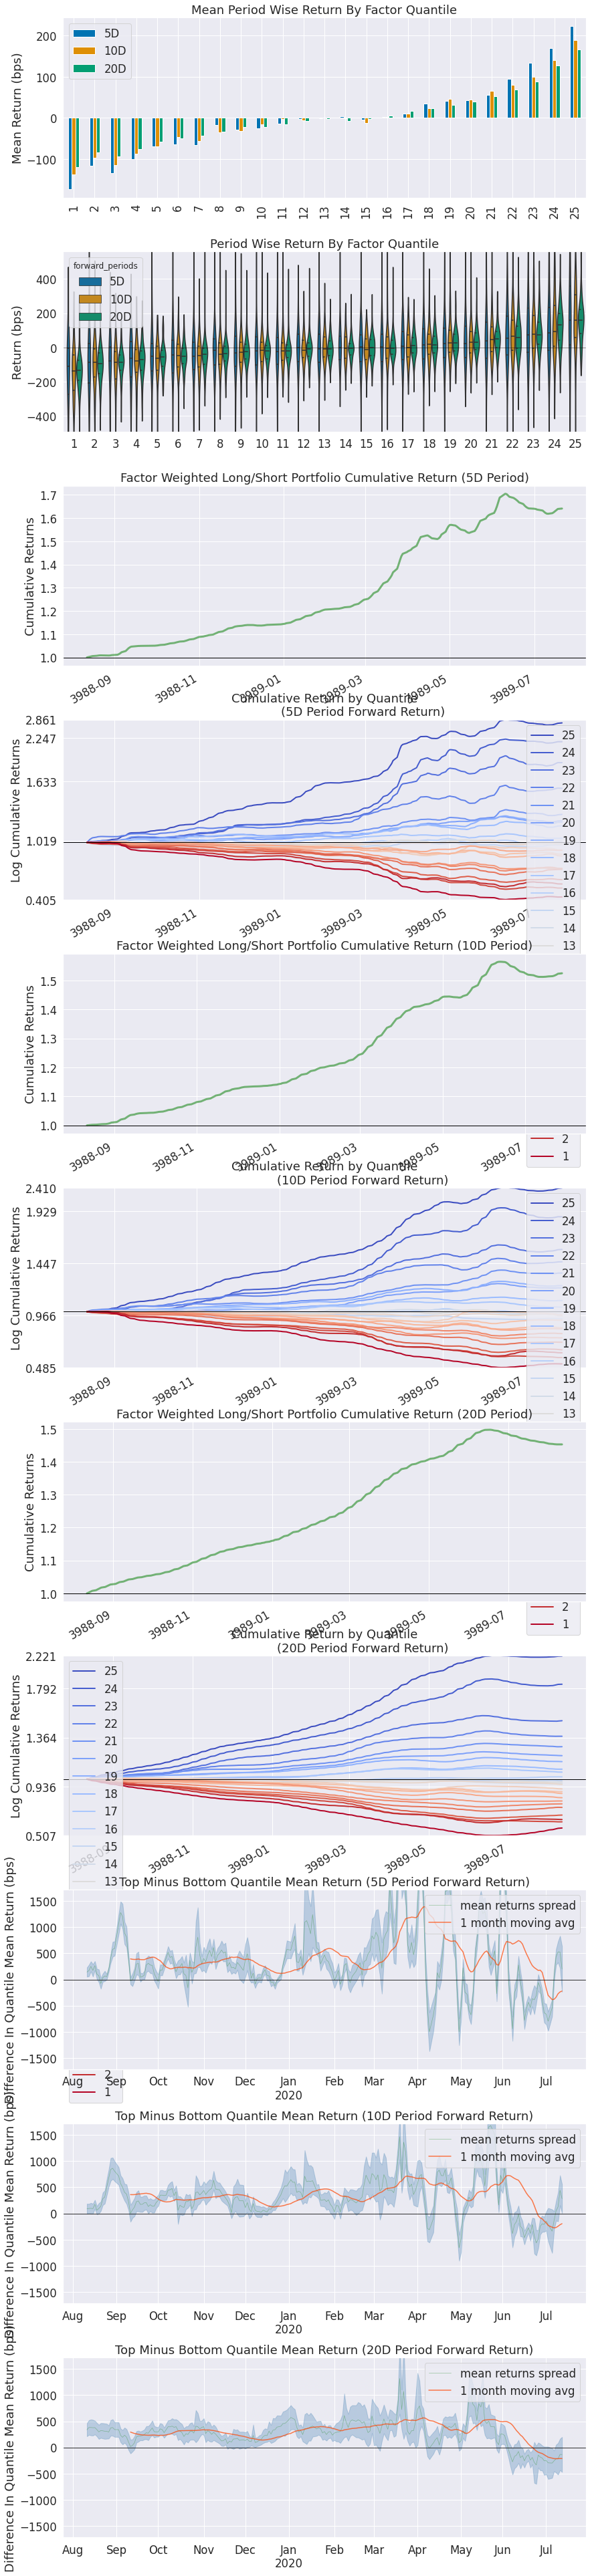

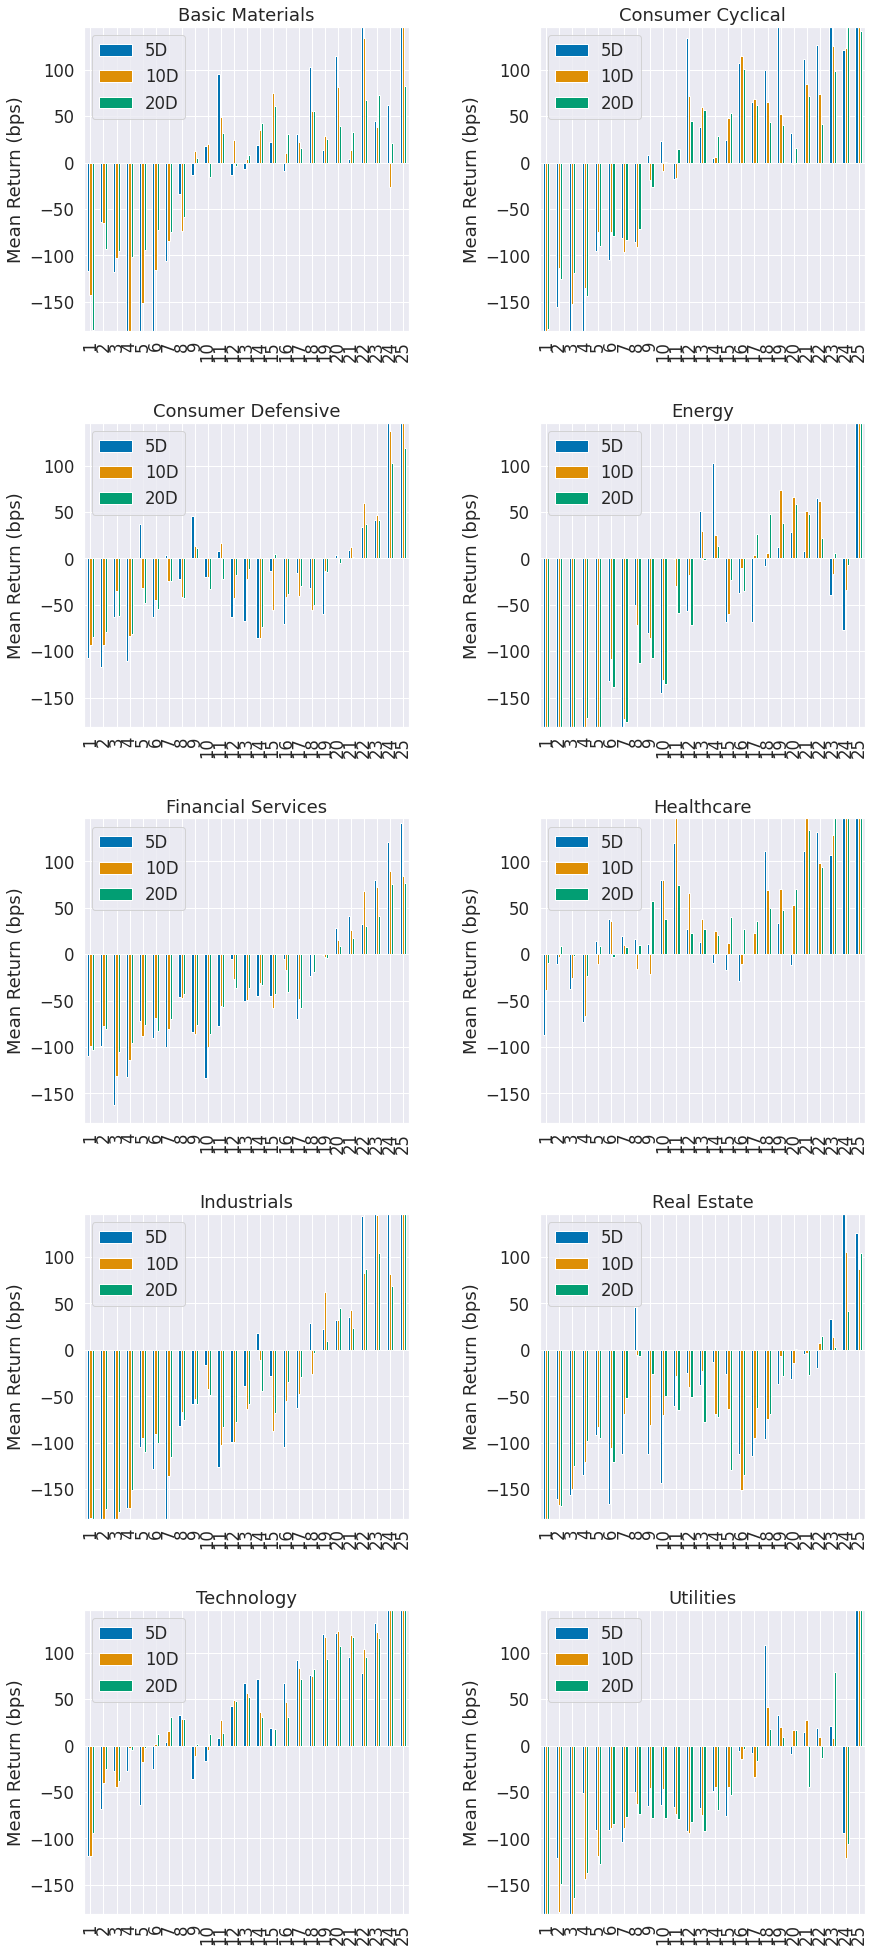

Information Analysis


5D     10D     20D
IC Mean           0.127   0.183   0.248
IC Std.           0.213   0.207   0.201
Risk-Adjusted IC  0.599   0.886   1.237
t-stat(IC)        9.130  13.497  18.841
p-value(IC)       0.000   0.000   0.000
IC Skew          -0.286  -0.805  -1.208
IC Kurtosis      -0.152   0.140   0.662

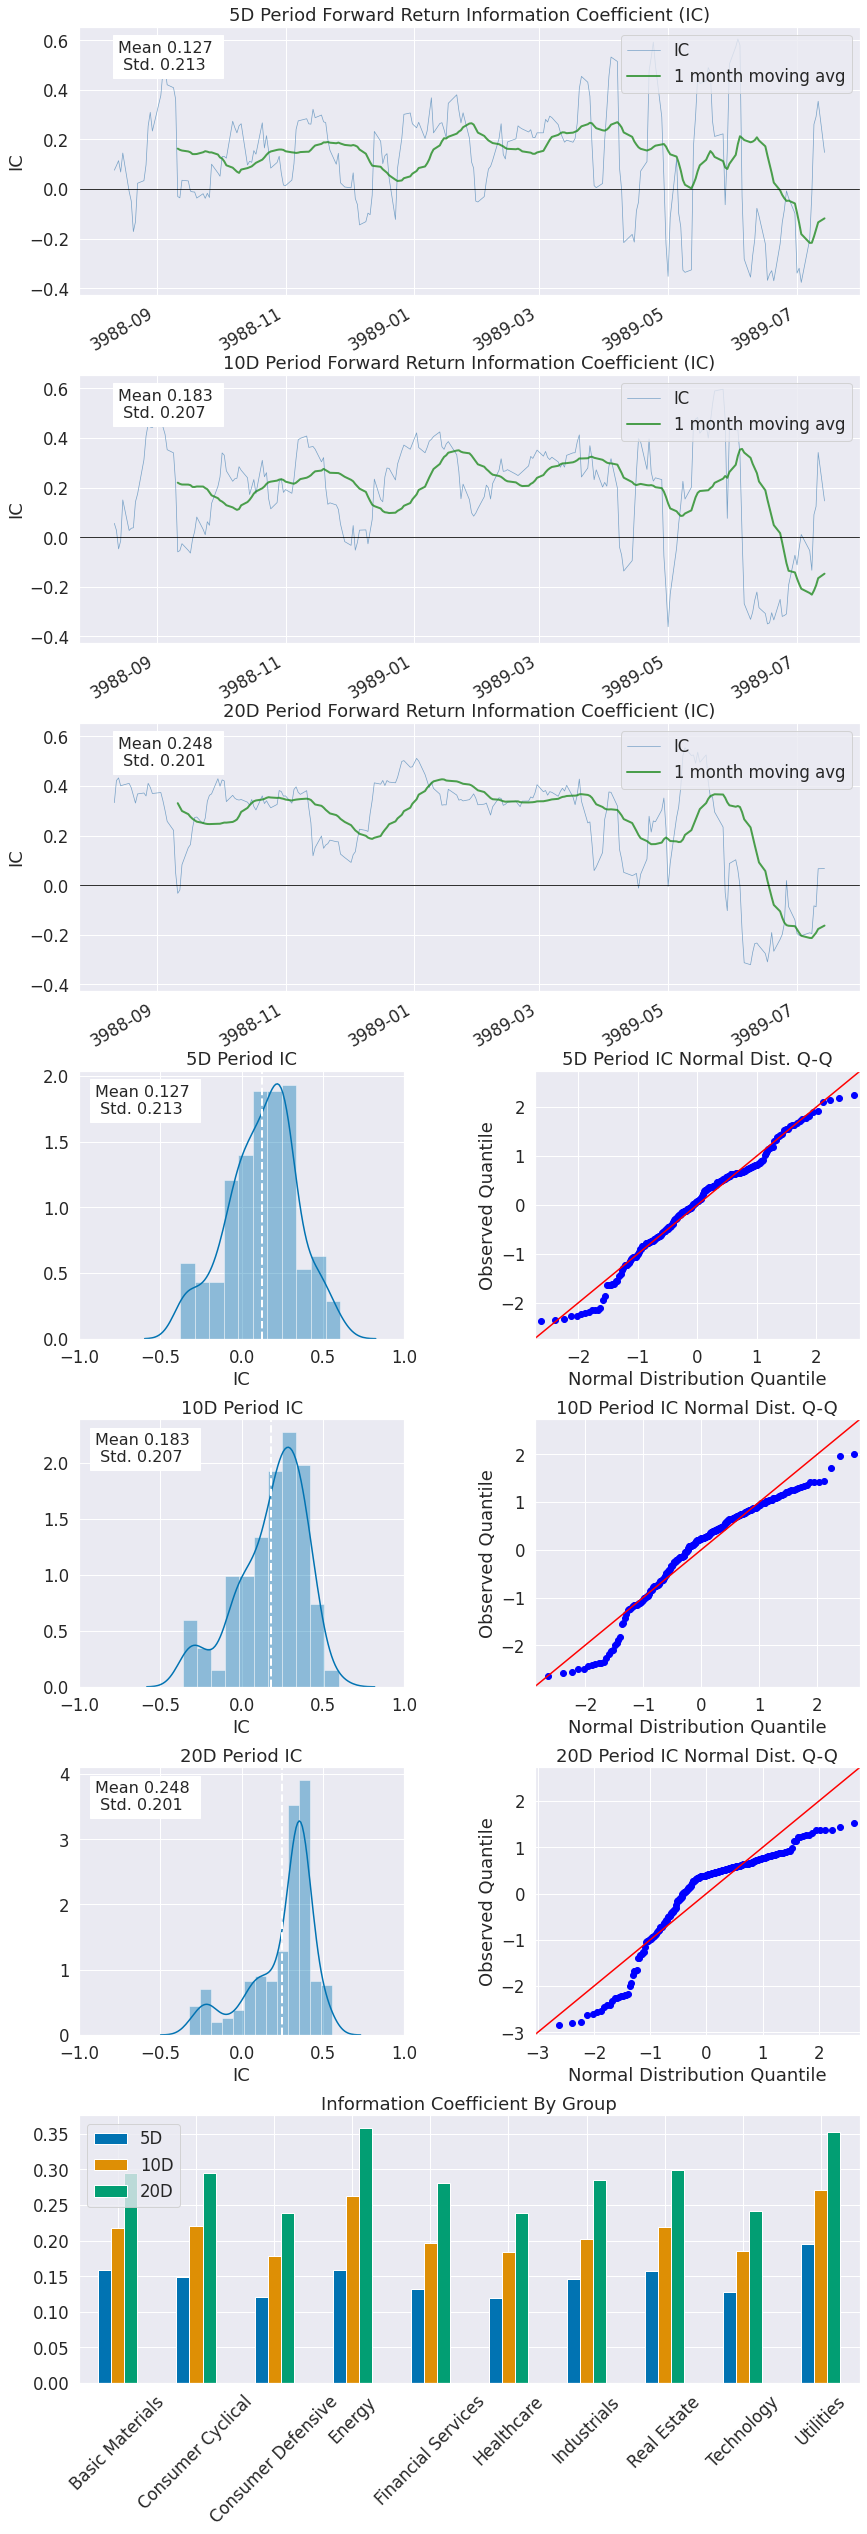

Turnover Analysis


10D    20D     5D
Quantile 1 Mean Turnover    0.598  0.788  0.440
Quantile 2 Mean Turnover    0.797  0.871  0.708
Quantile 3 Mean Turnover    0.866  0.914  0.785
Quantile 4 Mean Turnover    0.888  0.916  0.834
Quantile 5 Mean Turnover    0.891  0.924  0.833
Quantile 6 Mean Turnover    0.899  0.929  0.843
Quantile 7 Mean Turnover    0.906  0.942  0.856
Quantile 8 Mean Turnover    0.920  0.941  0.860
Quantile 9 Mean Turnover    0.915  0.944  0.868
Quantile 10 Mean Turnover   0.912  0.945  0.883
Quantile 11 Mean Turnover   0.923  0.949  0.881
Quantile 12 Mean Turnover   0.919  0.945  0.884
Quantile 13 Mean Turnover   0.911  0.949  0.869
Quantile 14 Mean Turnover   0.920  0.940  0.873
Quantile 15 Mean Turnover   0.928  0.954  0.881
Quantile 16 Mean Turnover   0.923  0.939  0.868
Quantile 17 Mean Turnover   0.908  0.944  0.875
Quantile 18 Mean Turnover   0.919  0.942  0.871
Quantile 19 Mean Turnover   0.898  0.939  0.848
Quantile 20 Mean Turnover   0.892  0.927  0.849
Quantile 21 Mean Turnover   0.882  0.917  0.834
Quantile 22 Mean Turnover   0.878  0.907  0.832
Quantile 23 Mean Turnover   0.848  0.908  0.769
Quantile 24 Mean Turnover   0.811  0.876  0.729
Quantile 25 Mean Turnover   0.636  0.847  0.448

5D    10D    20D
Mean Factor Rank Autocorrelation  0.885  0.777  0.596

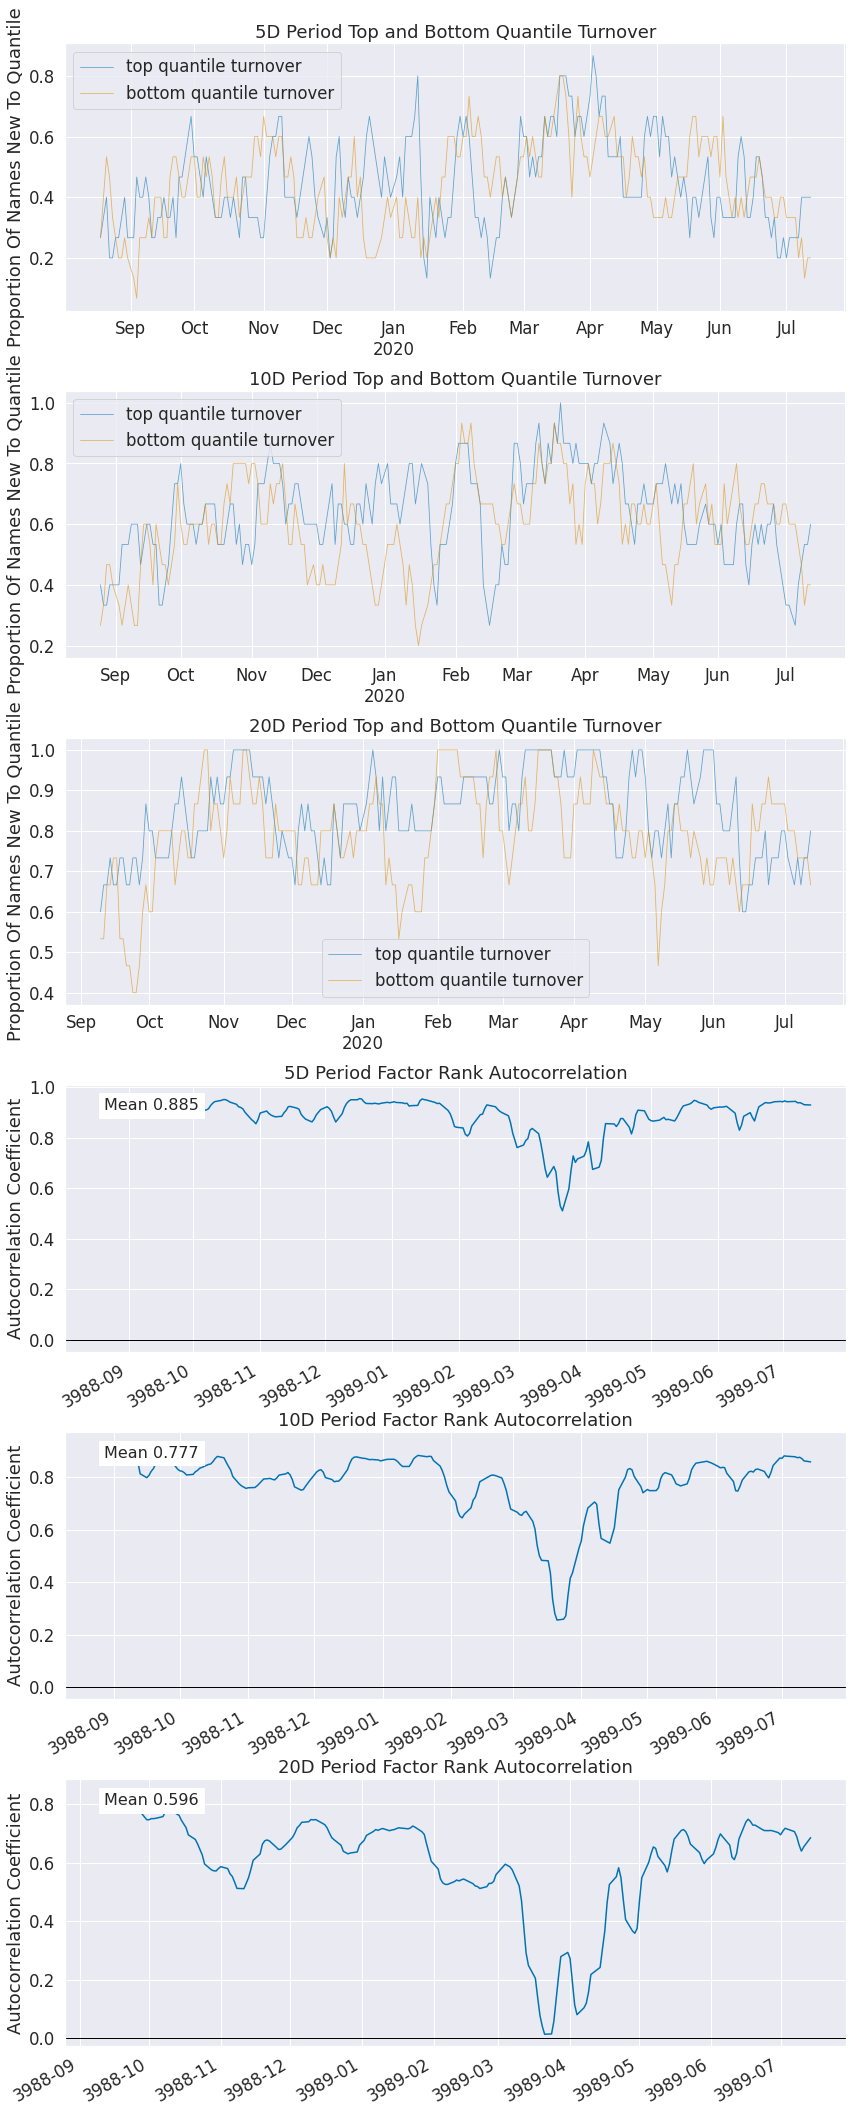

In [94]:
al.tears.create_full_tear_sheet(factor_data, by_group=True, long_short=True, group_neutral=False);

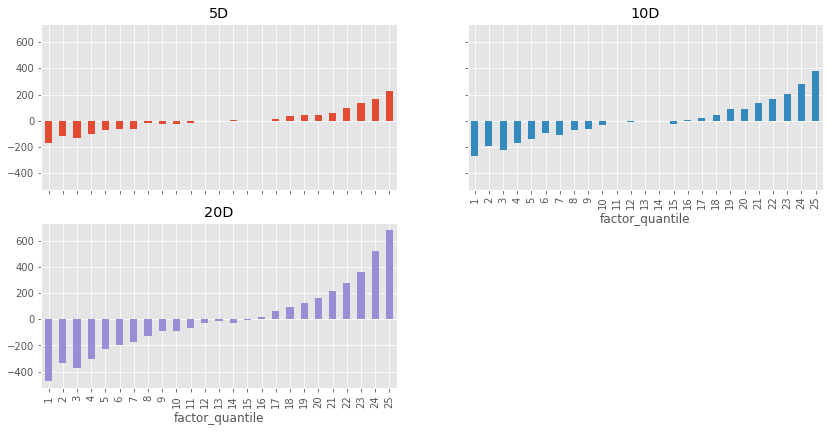

In [95]:
qr_factor_returns = pd.DataFrame()

qr_factor_returns = al.performance.mean_return_by_quantile(factor_data)[0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False);

In [96]:
ls_factor_returns = al.performance.factor_returns(factor_data)

In [97]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

5D      8.33
10D    12.33
20D    16.57
dtype: float64

# 7 -  Risk analysis 

In [98]:
dff = pd.DataFrame()
dff['factor'] =all_factors['alpha_vector']
df_all_weights = al.performance.factor_weights(dff, demeaned=True, group_adjust=False, equal_weight=False)
all_weights = df_all_weights.loc[pd.IndexSlice[all_factors.index.levels[0][-1]]]
all_weights = pd.DataFrame(data = all_weights.values, 
                                           columns = ['optimal_weights'],
                                           index = all_weights.index)
all_weights.index.name = 'asset'

In [99]:
assets = all_weights.index

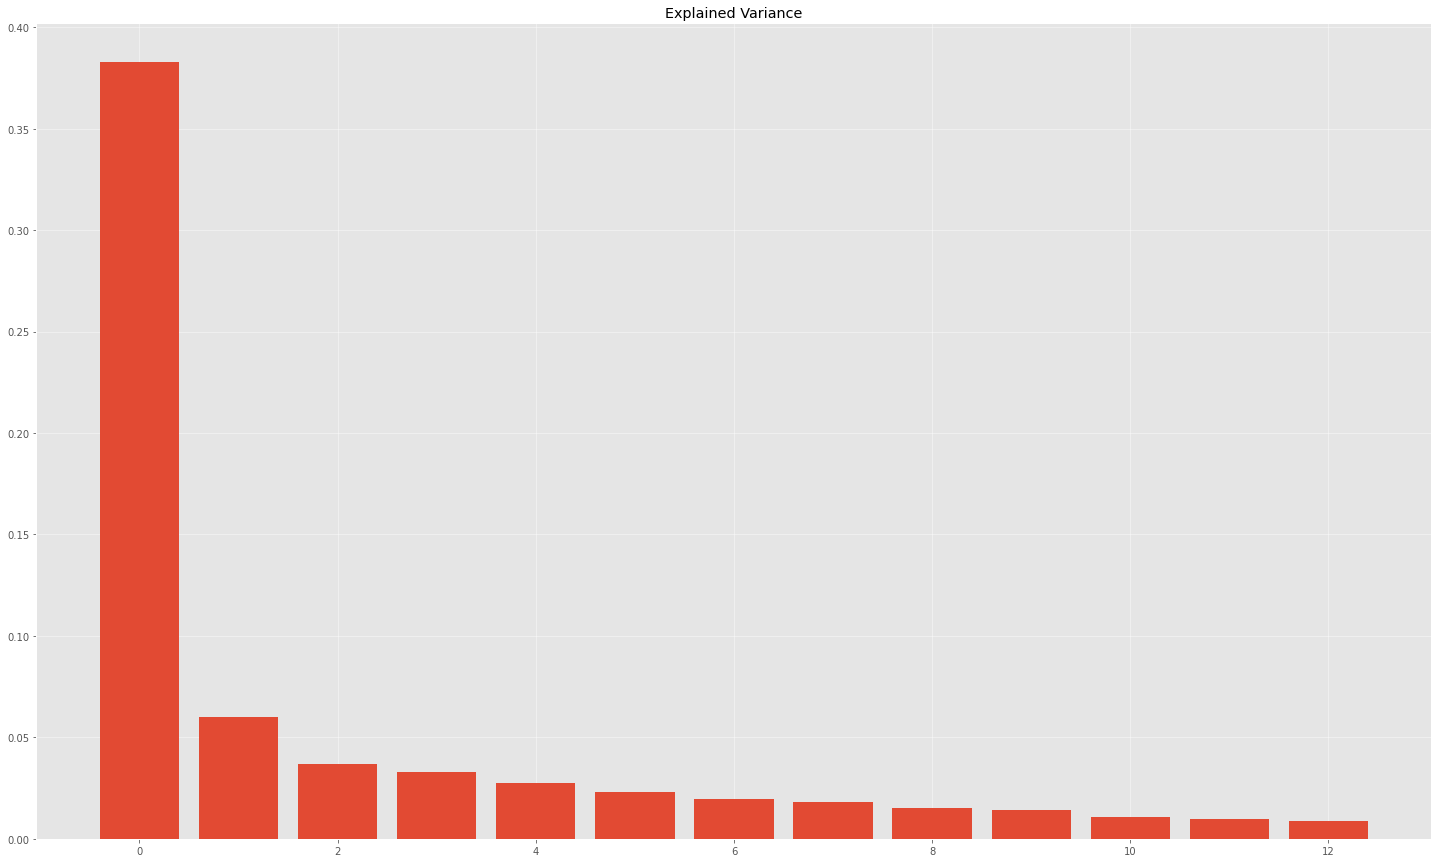

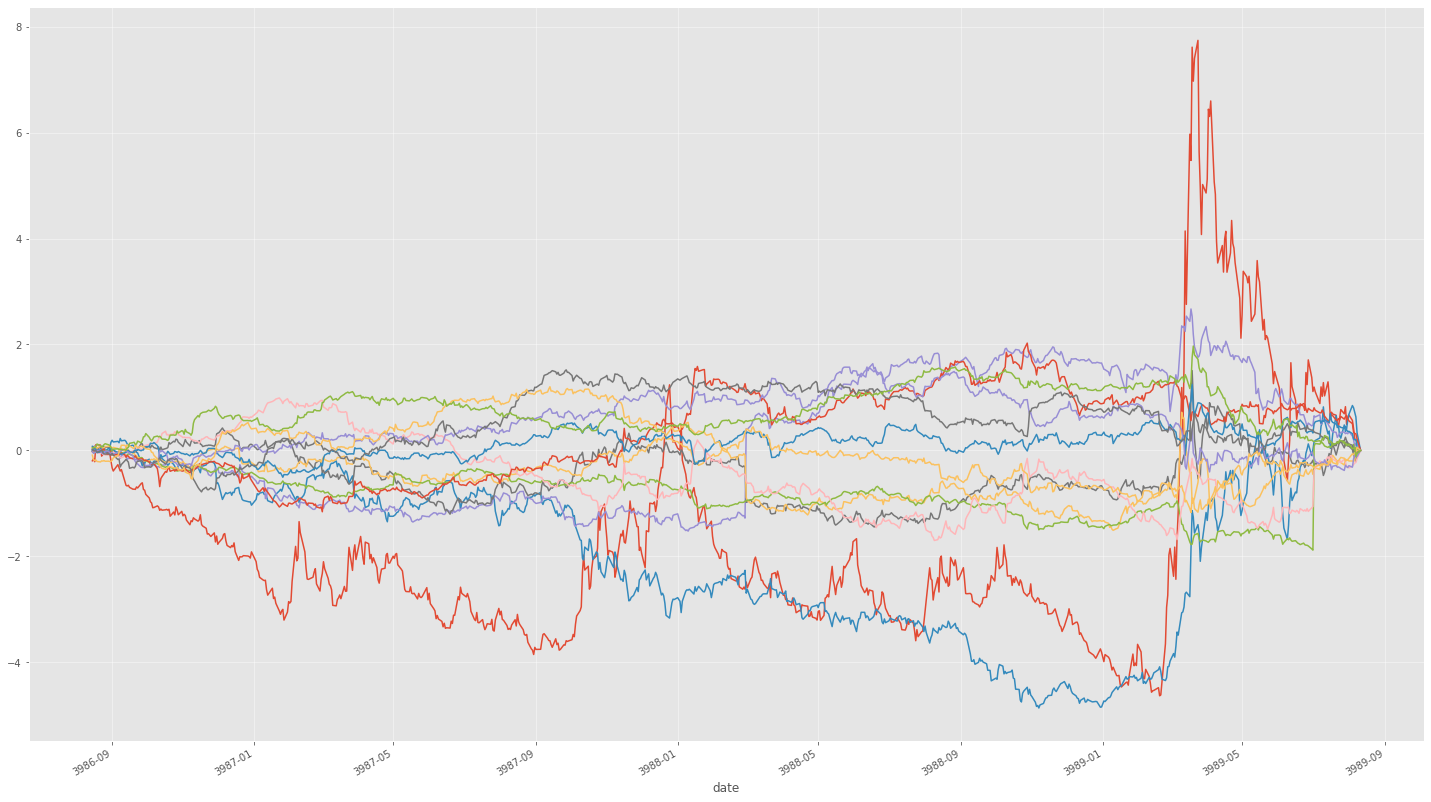

In [100]:
predicted_portfolio_risk,Risk_Model = risk_model.portfolio_risk(close[assets],num_factor_exposures=13,weights=all_weights)

In [101]:
print ('Predicted Risk: {} %'.format(np.round((predicted_portfolio_risk*100),2)))

Predicted Risk: 3.17 %


# 8 - Integrating factor data to optimzer

Once alpha model and a risk model are generated, we want to find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the [risk_model](https://github.com/keyvantaj/Quantitative/blob/master/risk_model.py). The [cxpy](https://www.cvxpy.org/) package is used to implement the [optimizer](https://github.com/keyvantaj/Quantitative/blob/master/optimizer.py)

The CVXPY objective function is to maximize 𝛼𝑇 ∗ 𝑥 , where x is the portfolio weights and alpha is the alpha vector.

In the other hand we have the following constraints:

- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where x is the portfolio weights, B is the factor betas, and r is the portfolio risk calculated in [risk model](https://github.com/keyvantaj/Quantitative/blob/master/risk_model.py) module.

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

In [102]:
optimal = pd.DataFrame(index = all_factors.index.levels[0], columns = all_factors.index.levels[1])
for date in all_factors.index.levels[0]:
    
    x = all_factors[['alpha_vector']].loc[date.date(),:]
    optimal.loc[date] = optimizer\
                          .OptimalHoldingsRegularization(lambda_reg = lambda_reg,
                                                         risk_cap = risk_cap).find(
                                                            x, 
                                                            Risk_Model['factor_betas'], 
                                                            Risk_Model['factor_cov_matrix'], 
                                                            Risk_Model['idiosyncratic_var_vector']).values.flatten()
    
optimal = optimal.astype(np.float)
optimal_stacked = optimal.stack().to_frame('optimal_weights')

In [103]:
assert optimal_stacked.shape[0] == vec.shape[0]

## 8 - 1 - Quantile data

Before starting the factor analysis of the optimized alpha vector, we will define quantiles for data of each date. For this purpose, we use the `qunatile_portions` parameter defined previously to cut data with specific portions. Then we iterate over `optimal_stacked` and apply [pandas qcut](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.qcut.html) function for each date to finally stacked the data into a pandas data frame.

In [104]:
quantile_optimal_stacked = utils_s.quantilize(qunatile_portions, 
                                              optimal_stacked,
                                              'optimal_weights',
                                              'quantile',
                                              'sector',
                                               vec)

In [105]:
print ('quantiles:', list(set(quantile_optimal_stacked['quantile'].values)))

quantiles: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


## 8 - 2 - Quantiles indexing

The goal here is to select the edges using `quantile_to_analyse` previously define in <b>parameters</b> section. 

In [106]:
q_final_vector = utils_s.q_indexing(quantile_to_analyse, quantile_optimal_stacked)

In [107]:
percent_q_dropped = ((quantile_optimal_stacked.shape[0] - q_final_vector.shape[0])/quantile_optimal_stacked.shape[0])*100
print ('{} % dropped after qunatile select'.format(np.round(percent_q_dropped,2)))

91.87 % dropped after qunatile select


In [108]:
assert quantile_to_analyse == list(set(q_final_vector['quantile'].values))

In [109]:
print ('selected quantiles:', list(set(q_final_vector['quantile'].values)))

selected quantiles: [1, 25]


## 8 - 3 - Sectors Selected

In [110]:
final_vector,sectors = utils_s.select_sector(q_final_vector, drop_long_sec, drop_short_sec,
                                     sec_col='sector',factor_col = 'quantile')

In [111]:
print ('{} rows dropped after sector select'.format(q_final_vector.shape[0] - final_vector.shape[0]))

0 rows dropped after sector select


# 9 - Optimized alpha vector analysis 

## 9 - 1 - Creating clean factor data

In [112]:
factor_data = al.utils.get_clean_factor_and_forward_returns(factor = final_vector['optimal_weights'], 
                                                          prices = pricing, 
                                                          periods = combined_periods,
                                                          quantiles = len(quantile_to_analyse),
                                                          groupby=sectors,
                                                          binning_by_group=False,
                                                          filter_zscore=20,
                                                          max_loss=0.15)

Dropped 7.9% entries from factor data: 7.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 15.0%, not exceeded: OK!


## 9 - 2 - Sector selection for factor data

In [113]:
factor_data, sectors = utils_s.select_sector(factor_data, drop_long_sec, drop_short_sec,
                                     sec_col='group',factor_col = 'factor_quantile')

In [114]:
print ('{} rows dropped from factor data'.format(factor_data.shape[0] - factor_data.shape[0]))

0 rows dropped from factor data


## 9 - 3 - Creating tear sheets 

In [115]:
pf_returns, pf_positions, pf_benchmark = \
al.performance.create_pyfolio_input(factor_data,
                                   period = '{}D'.format(rebalance_period),
                                   capital = 1,
                                   long_short = True,
                                   group_neutral = False,
                                   equal_weight = False,
                                   groups = sectors)

pf_benchmark = benchmark.loc[slice(pf_returns.index[0],pf_returns.index[-1])]
sec_mappings = sectors.loc[pd.IndexSlice[pf_returns.index[0]]]

sector_mappings = {}
for i in sec_mappings.index:
    sector_mappings[i] = sec_mappings.loc[i]

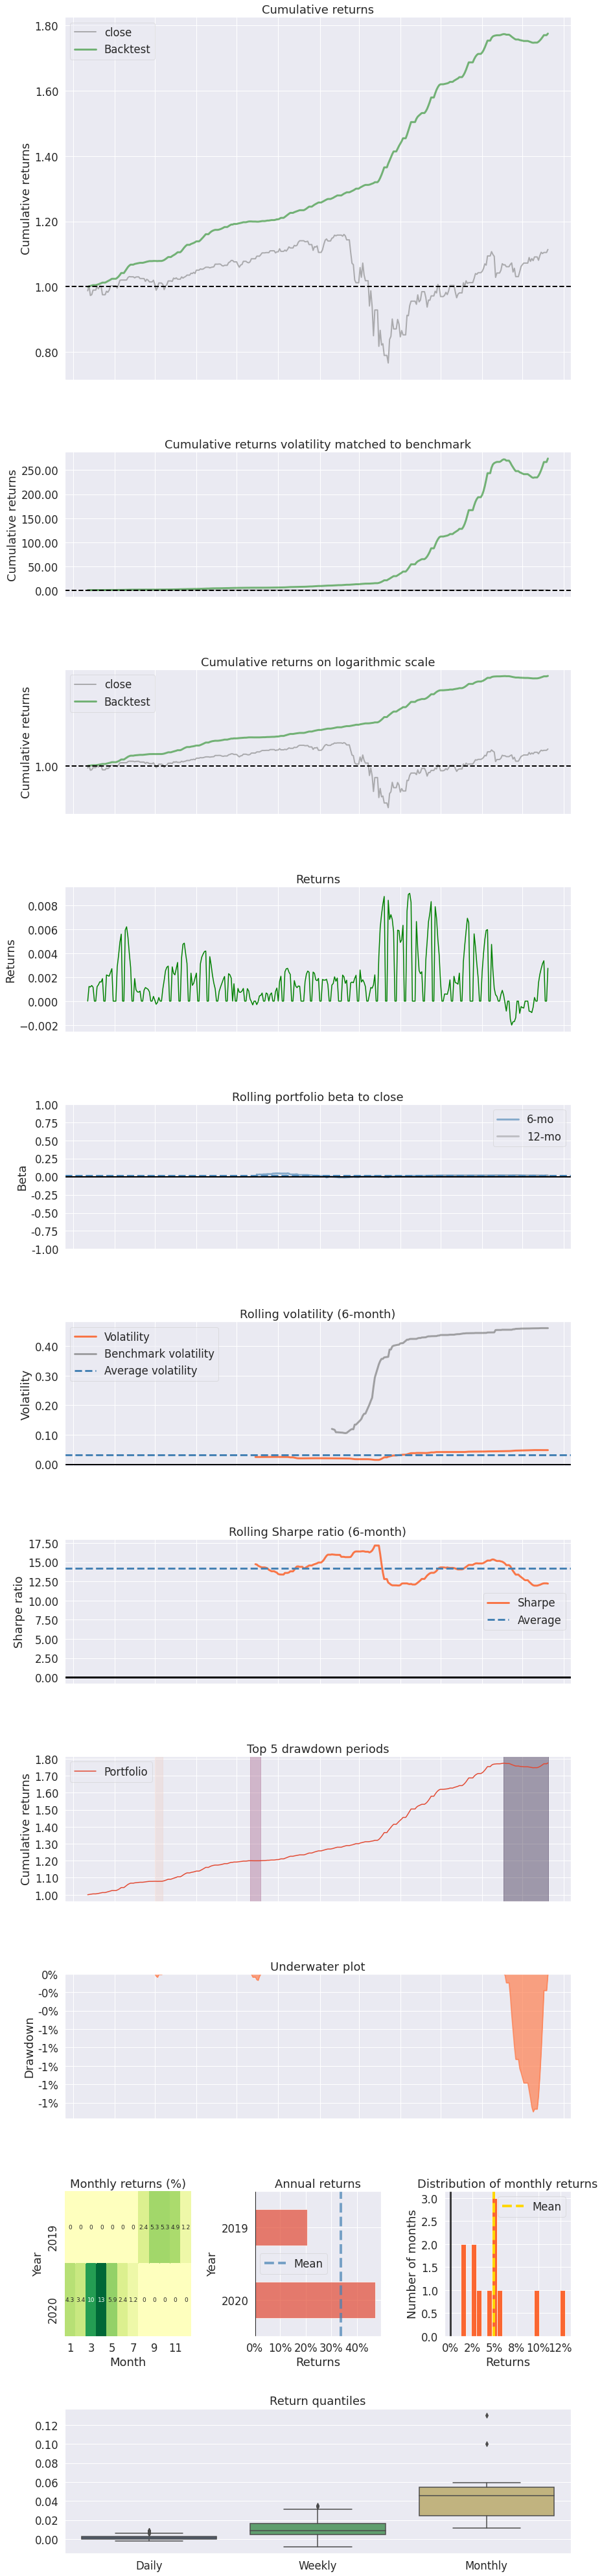

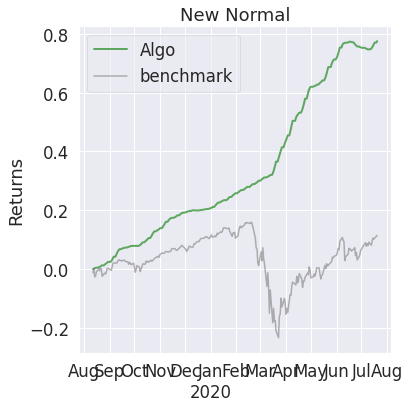

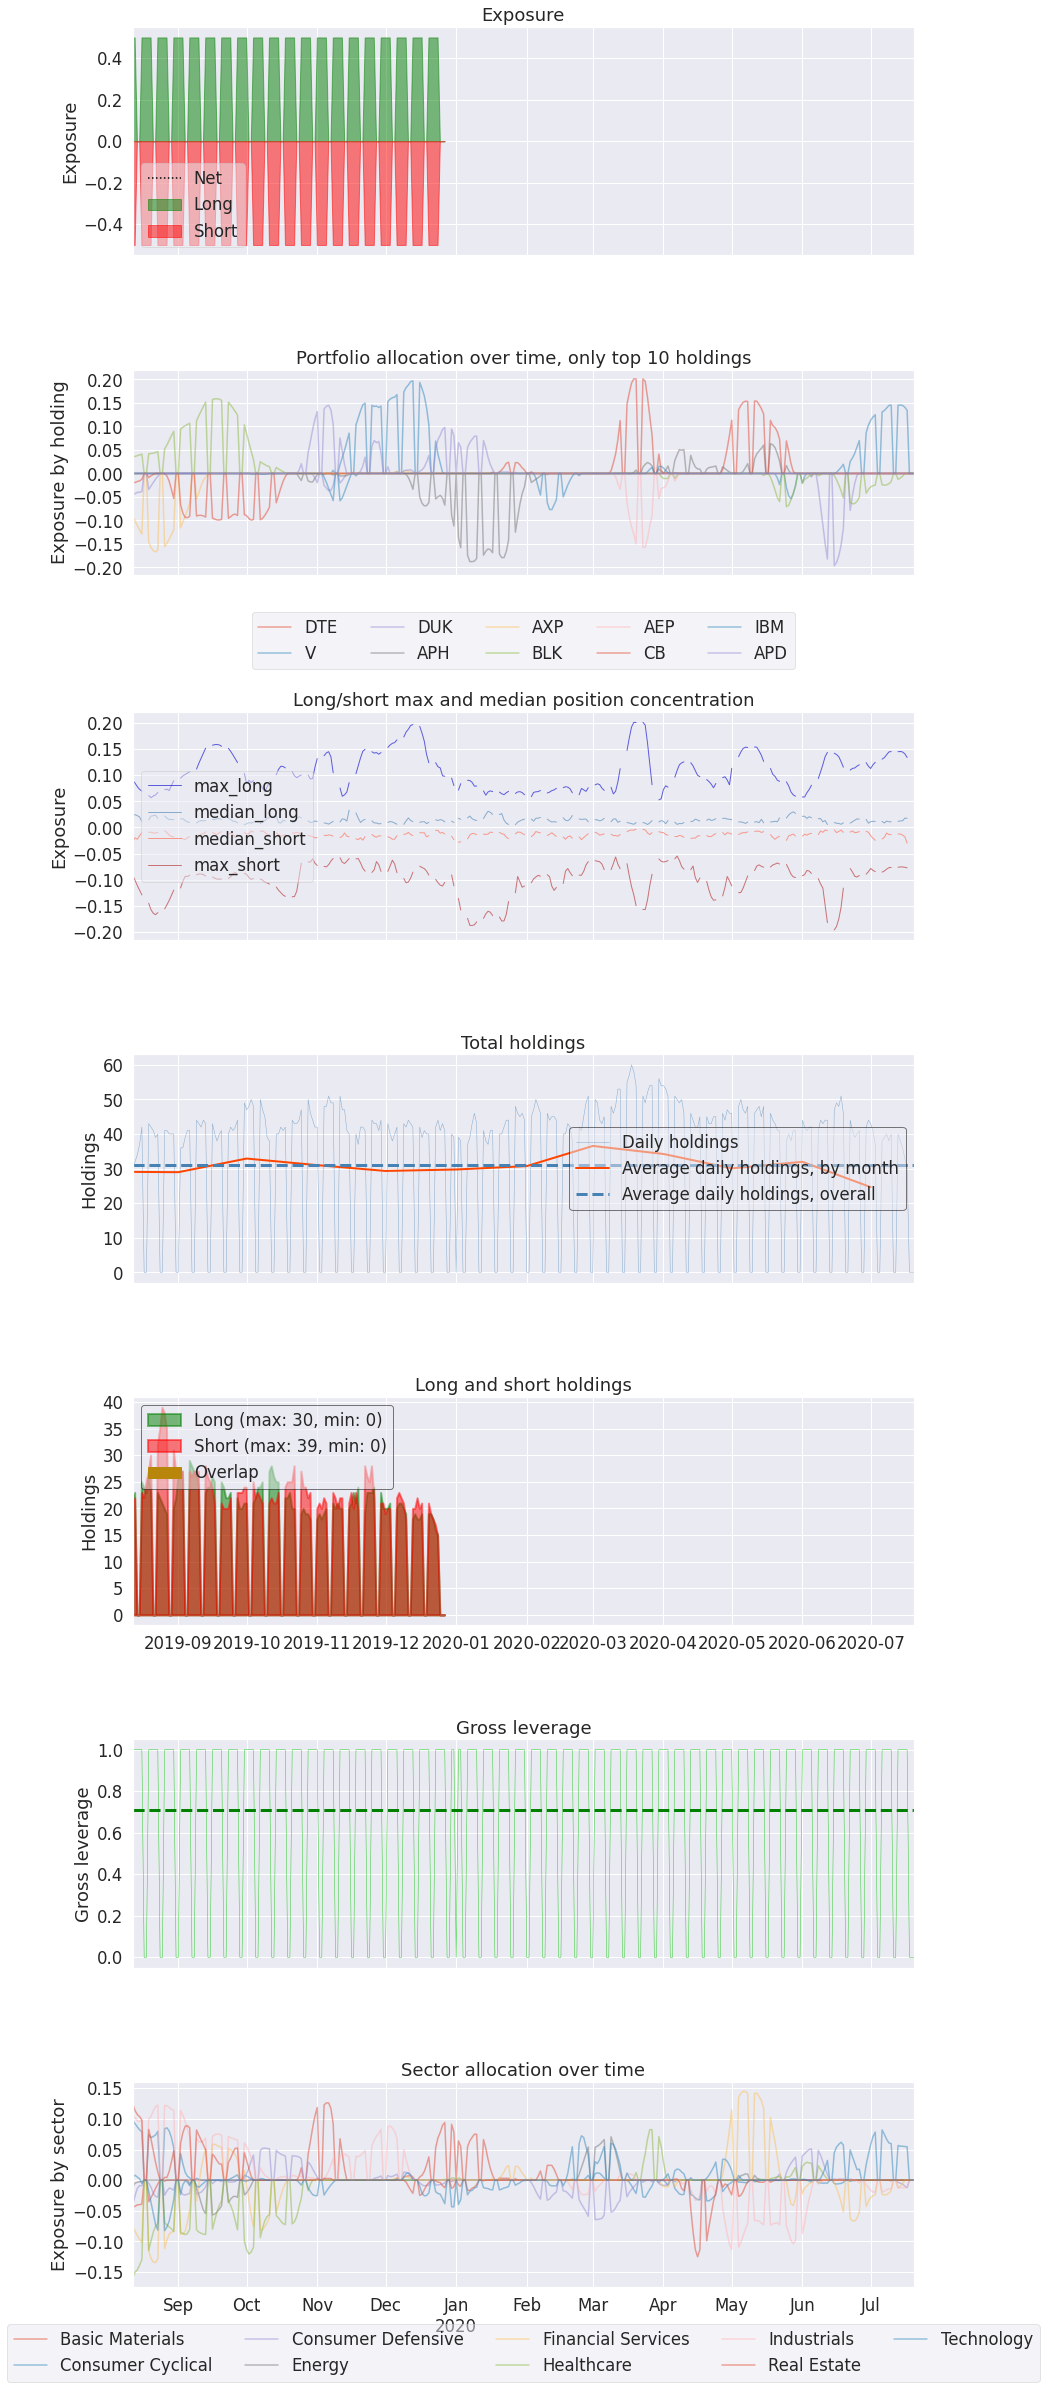

In [116]:
pf.create_full_tear_sheet(returns = pf_returns, 
                          positions = pf_positions,
                          sector_mappings = sector_mappings,
                          benchmark_rets = pf_benchmark,
                          factor_returns = factor_data[['factor']] )

Quantiles Statistics


min           max      mean       std  count  \
factor_quantile                                                          
1               -2.000000e-01 -8.290403e-10 -0.032481  0.028841   3480   
2                7.015982e-10  2.000000e-01  0.032703  0.030879   3480   

                 count %  
factor_quantile           
1                   50.0  
2                   50.0

Returns Analysis


5D      10D      20D
Ann. alpha                                       0.797    0.754    0.583
beta                                             0.112    0.103    0.091
Mean Period Wise Return Top Quantile (bps)     124.837  113.863   98.303
Mean Period Wise Return Bottom Quantile (bps) -124.837 -115.175 -101.291
Mean Period Wise Spread (bps)                  249.674  229.081  199.728

<Figure size 1800x1080 with 0 Axes>

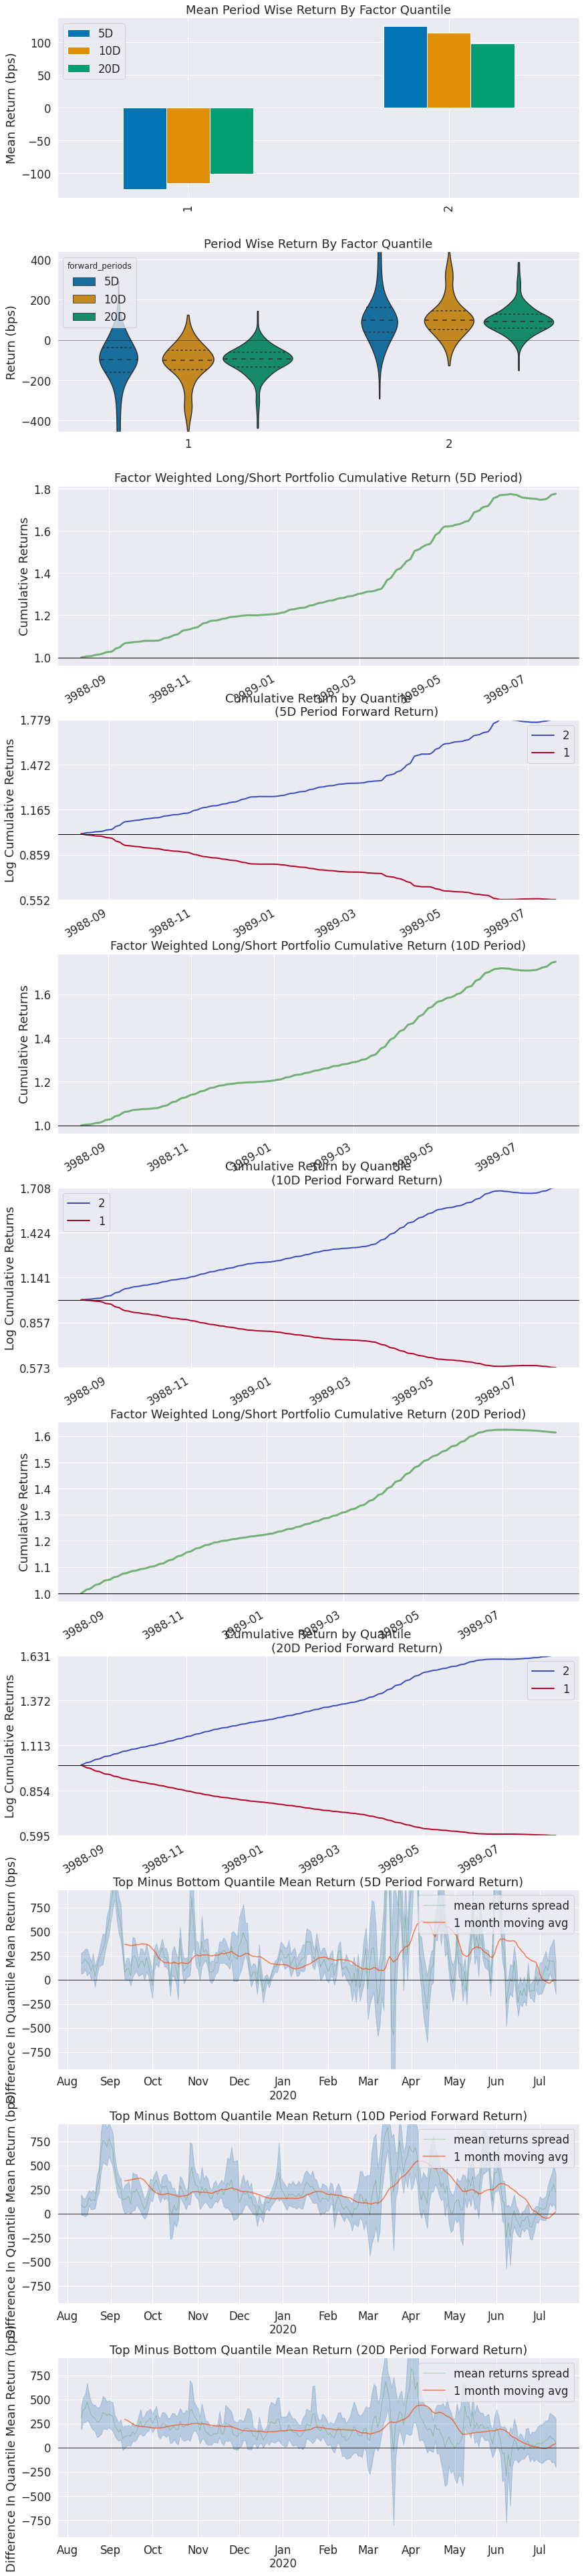

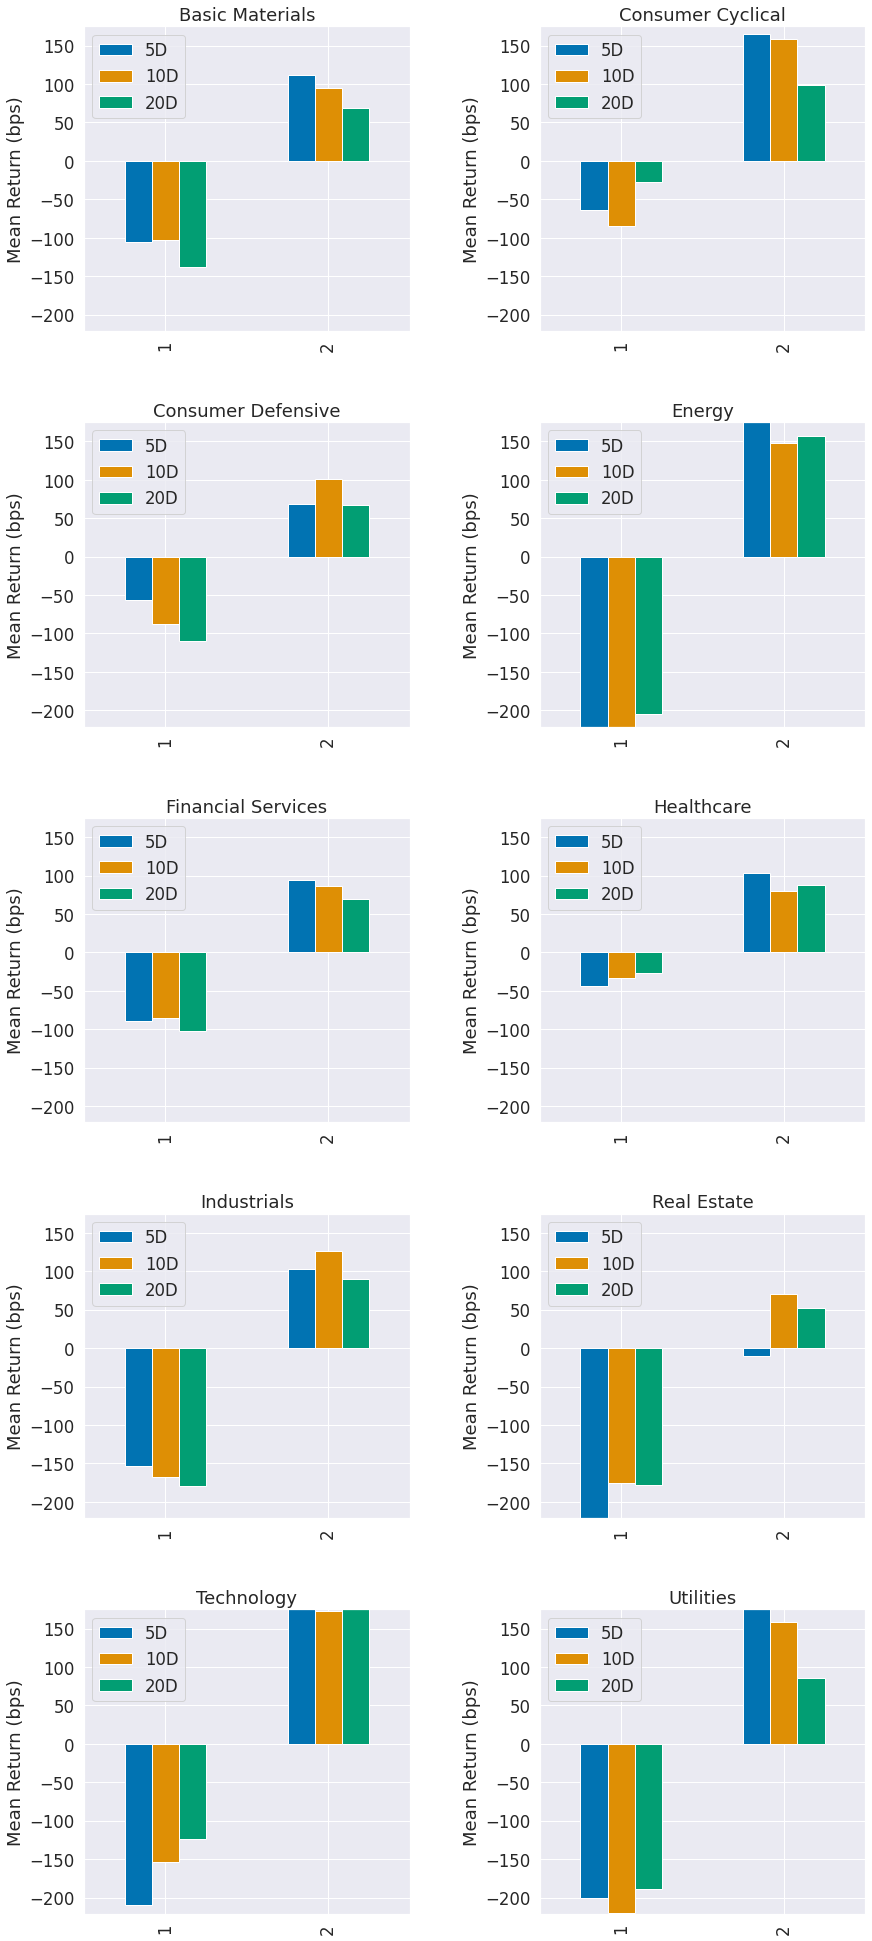

Information Analysis


5D     10D     20D
IC Mean            0.220   0.307   0.395
IC Std.            0.213   0.224   0.237
Risk-Adjusted IC   1.032   1.371   1.670
t-stat(IC)        15.723  20.880  25.433
p-value(IC)        0.000   0.000   0.000
IC Skew           -0.244  -0.625  -0.820
IC Kurtosis       -0.268  -0.139   0.085

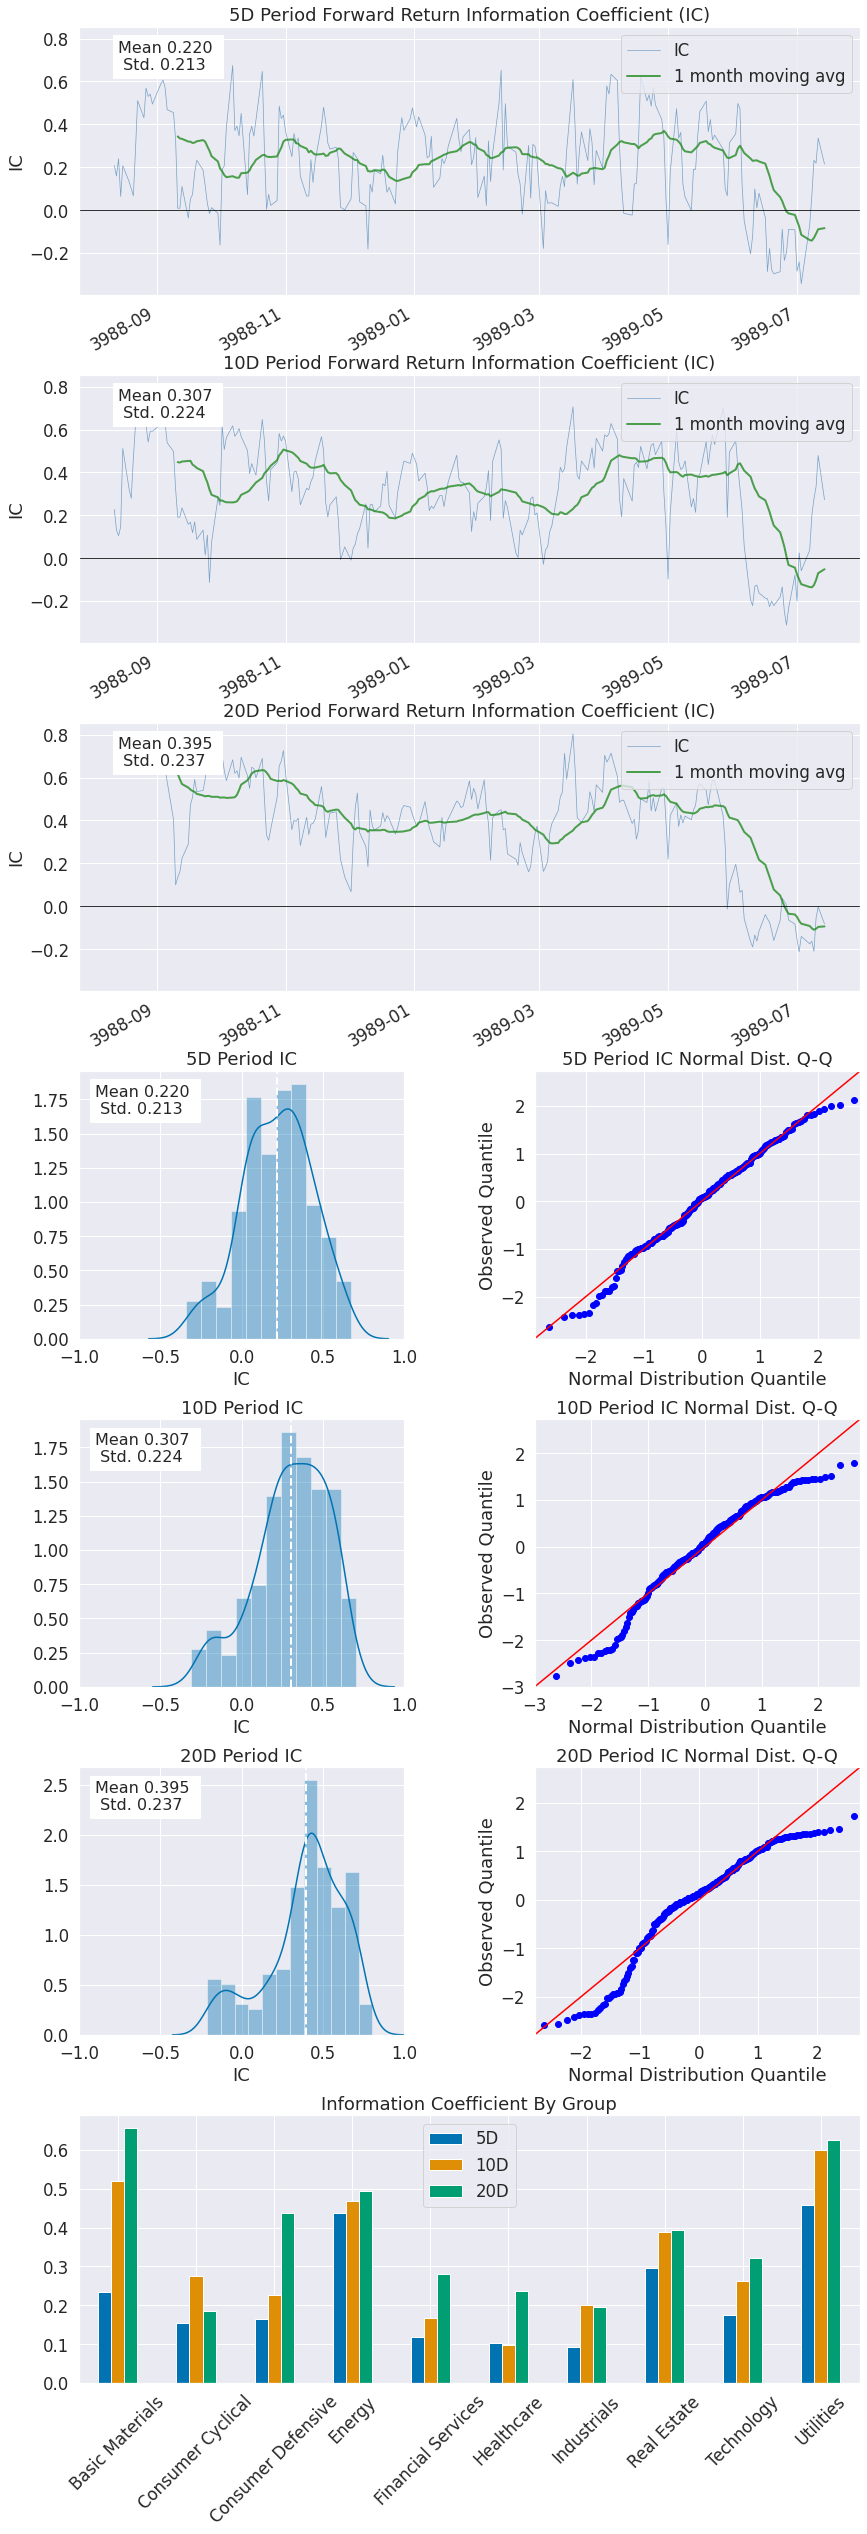

Turnover Analysis


10D    20D     5D
Quantile 1 Mean Turnover   0.615  0.766  0.446
Quantile 2 Mean Turnover   0.645  0.861  0.456

5D    10D    20D
Mean Factor Rank Autocorrelation  0.893  0.844  0.817

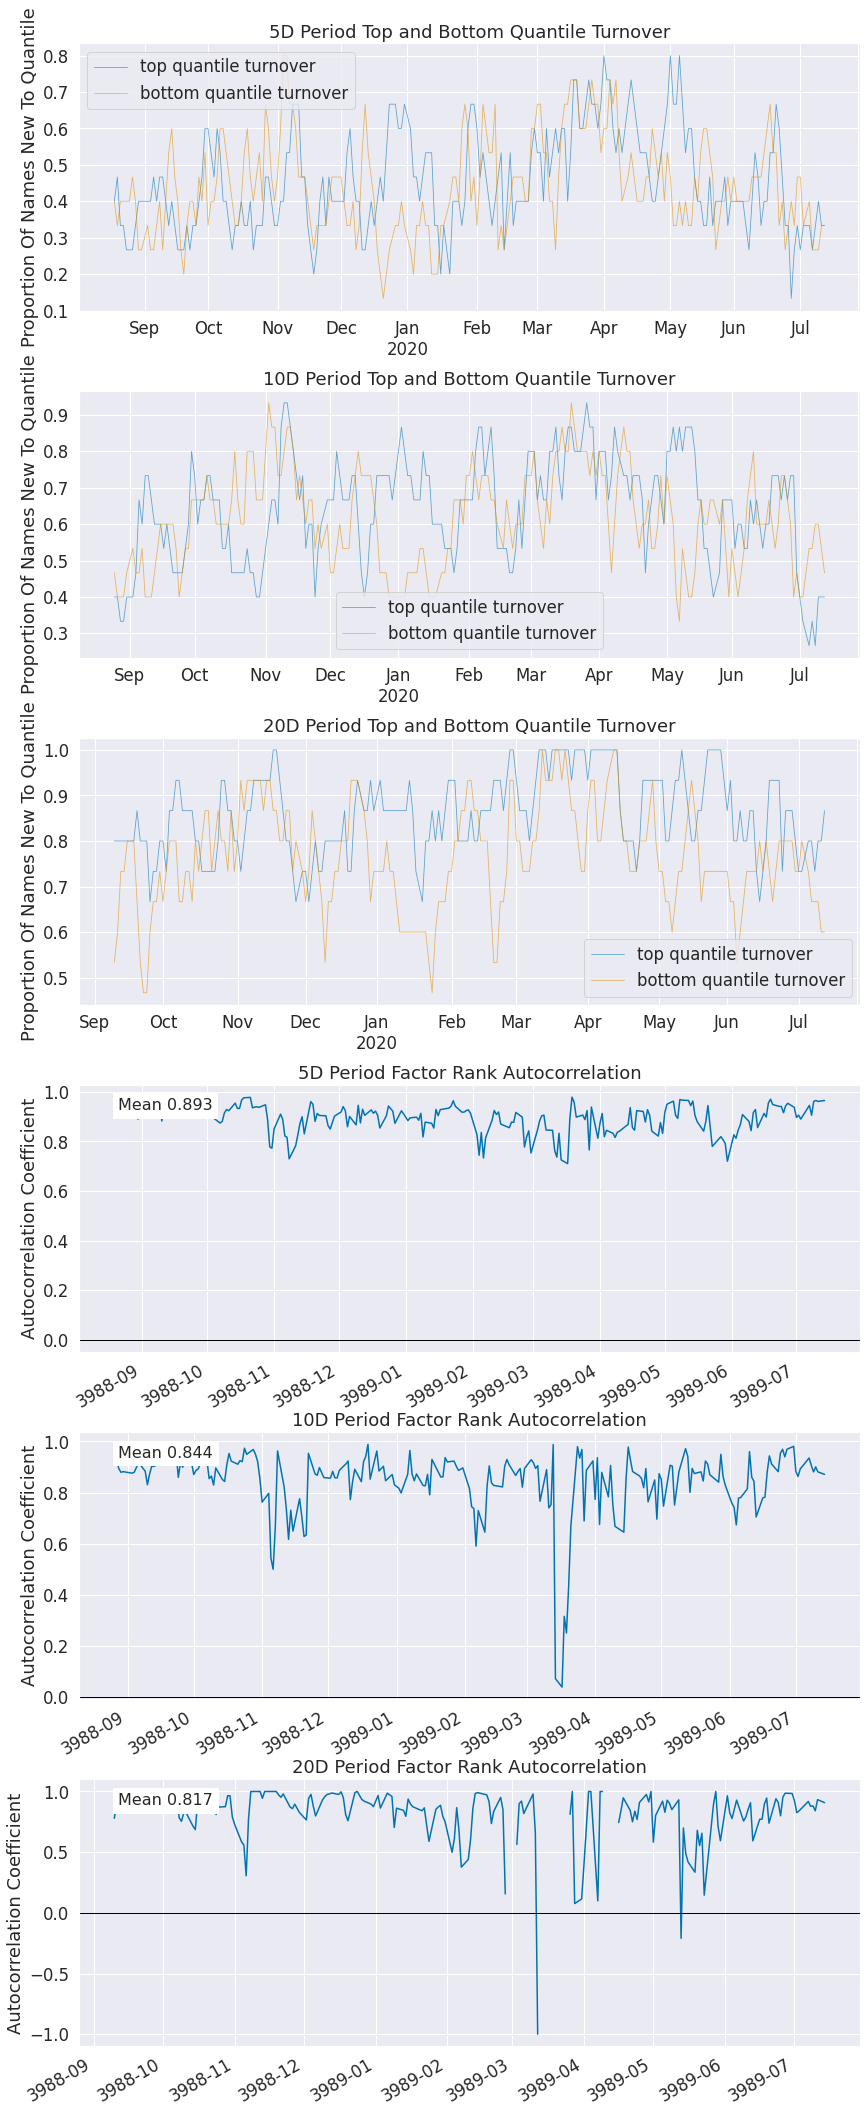

In [117]:
al.tears.create_full_tear_sheet(factor_data, by_group=True, long_short=True, group_neutral=False);

In [118]:
ls_factor_returns = al.performance.factor_returns(factor_data)

In [119]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

5D     14.29
10D    19.43
20D    22.91
dtype: float64

# 10 - Predicted Portfolio

In [120]:
optimal_weights_regularized = final_vector[['optimal_weights']].loc[final_vector.index.levels[0][-1]]

for 30 assets  with end date: 2020-08-10 00:00:00+00:00


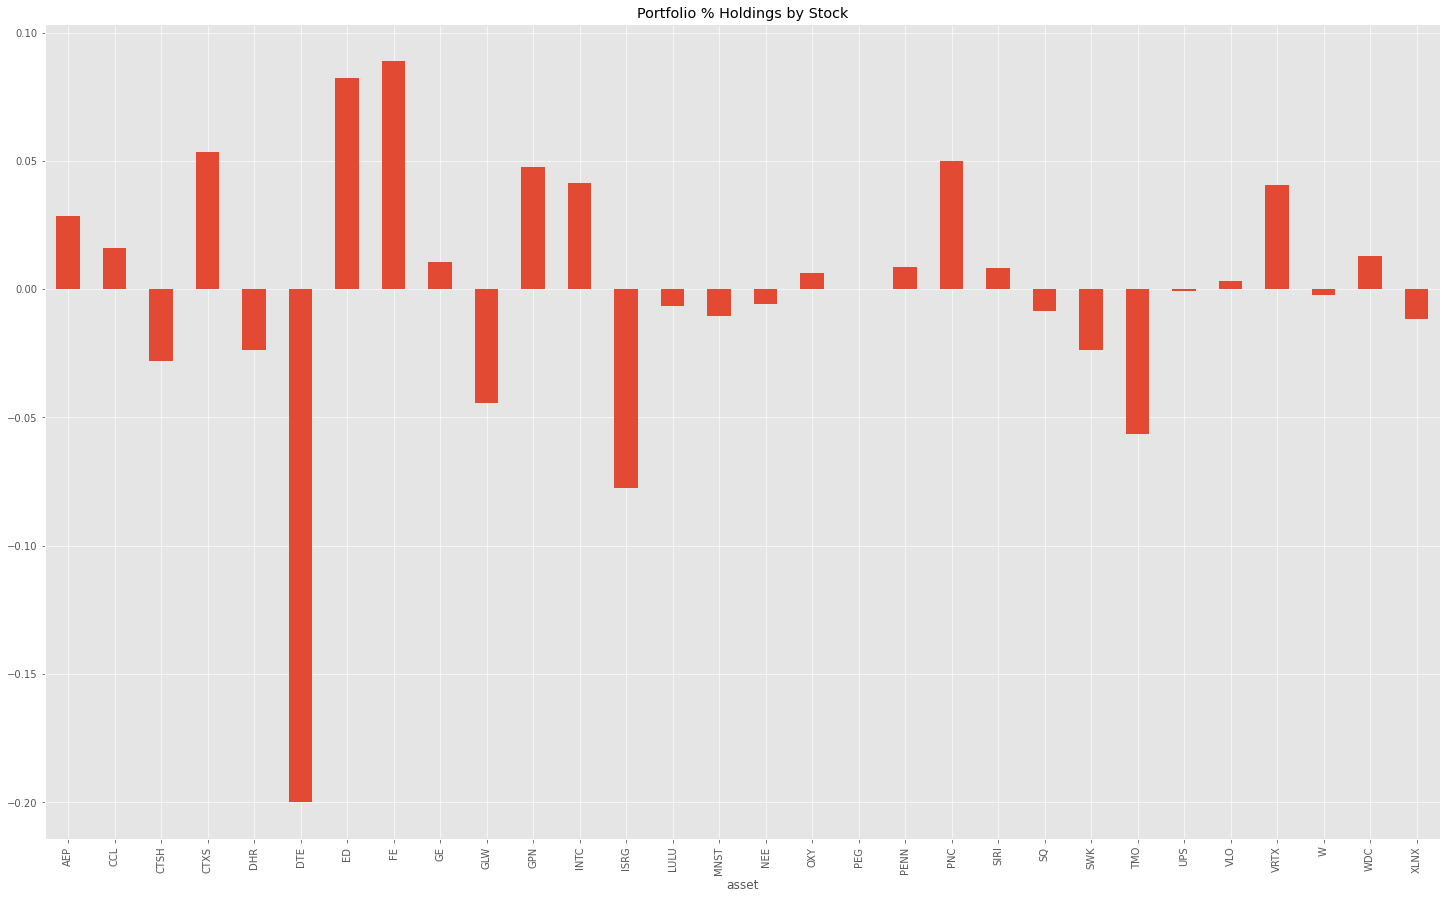

In [121]:
print ('for {} assets  with end date: {}'.format(len(optimal_weights_regularized.index),optimal.index[-1]))
optimal_weights_regularized.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
plt.grid(alpha=0.8)

In [122]:
optimal_weights_regularized = pd.DataFrame(data = optimal_weights_regularized.values, 
                                           columns = ['optimal_weights'],
                                           index = optimal_weights_regularized.index)
optimal_weights_regularized.index.name = 'asset'

In [123]:
q5 = optimal_weights_regularized.sort_values(by='optimal_weights',ascending=False)[:len(optimal_weights_regularized.index)//5]
q1 = optimal_weights_regularized.sort_values(by='optimal_weights',ascending=True)[:len(optimal_weights_regularized.index)//5]

In [124]:
print (q5.iloc[0])
print (q1.iloc[0])

optimal_weights    0.088863
Name: FE, dtype: float64
optimal_weights   -0.2
Name: DTE, dtype: float64


## 10 - 3 - Risk analysis with optimized weights

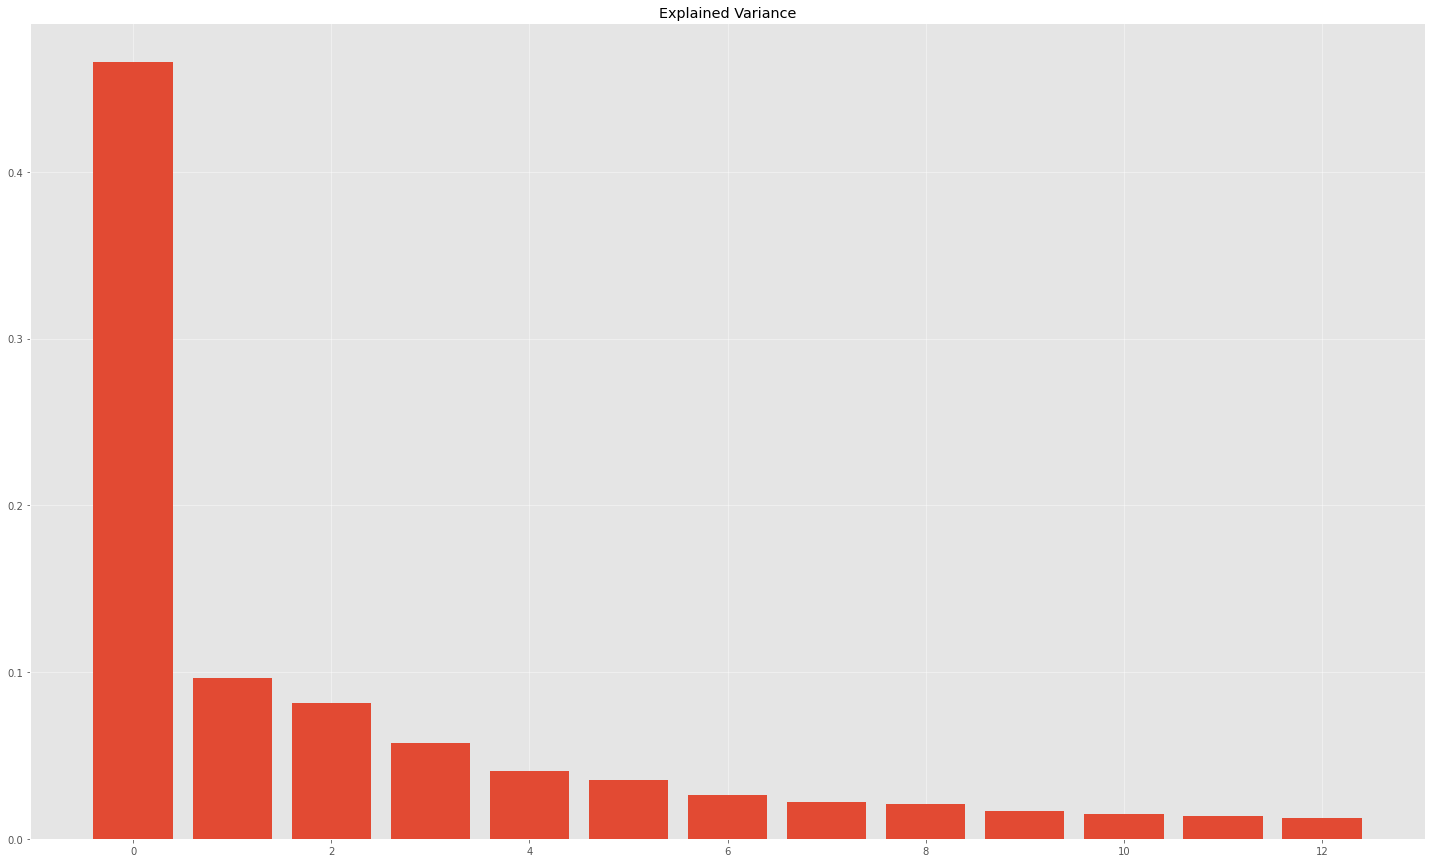

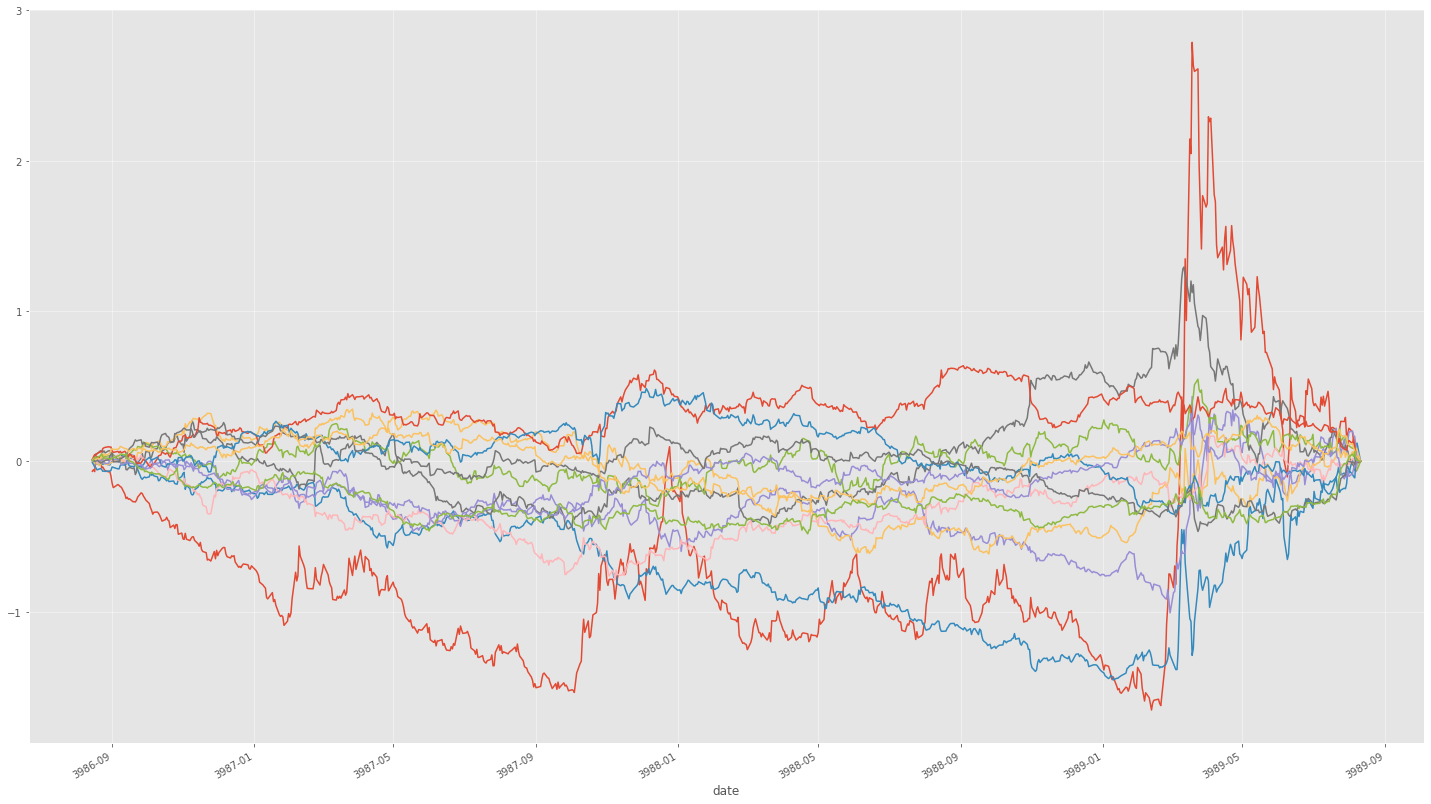

In [125]:
predicted_portfolio_risk,Risk_Model = risk_model.portfolio_risk(close[optimal_weights_regularized.index],num_factor_exposures=factor_exposures,weights=optimal_weights_regularized)

In [126]:
print ('Predicted Risk: {} %'.format(np.round((predicted_portfolio_risk*100),2)))

Predicted Risk: 5.33 %


In [127]:
close.to_csv('data/close.csv')
optimal_weights_regularized.to_csv('output/optimal_weights_regularized.csv')

In [128]:
print ('the total leverage is {}'.format(optimal_weights_regularized.abs().sum().round(2)[0]))
print ('the long/short leverage balance is {}'.format(optimal_weights_regularized.sum().round(2)[0]))

the total leverage is 1.0
the long/short leverage balance is -0.0


In [129]:
import vlc
p = vlc.MediaPlayer("End_of_Script.mp3")
p.play();